### Redfin

In [1]:
!pip install cohere

In [2]:
import pandas as pd

/Users/soumitra7/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import sys
print(sys.executable)


/Users/soumitra7/anaconda3/bin/python


In [4]:
!{sys.executable} -m pip install cohere


DEPRECATION: Loading egg at /Users/soumitra7/anaconda3/lib/python3.11/site-packages/pyBWMD-0.0.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [5]:
import pandas as pd
import cohere

class MarketAgent:
    def __init__(self, filepath, api_key):
        self.filepath = filepath
        self.api_key = api_key
        self.model = "command-r-plus"
        self.data = None
        self.cleaned_data = None
        self.llm_client = cohere.Client(self.api_key)
    
    def retrieve_data(self):
        # Load full Redfin dataset
        self.data = pd.read_csv(self.filepath, sep='\t')  # Redfin .tsv file
        print(f"Full Redfin data loaded: {self.data.shape[0]} rows, {self.data.shape[1]} columns")

        # Parse dates
        self.data['PERIOD_BEGIN'] = pd.to_datetime(self.data['PERIOD_BEGIN'], errors='coerce')
        self.data['PERIOD_END'] = pd.to_datetime(self.data['PERIOD_END'], errors='coerce')

        # No sampling! Keep everything
        print("Using the entire dataset without sampling.")

        return self.data

    
    # 2. Basic EDA
    def basic_eda(self):
        print("\nBasic EDA:")
        print(self.data.info())
        print("\nSummary Statistics:")
        print(self.data.describe())
        print("\nMissing Values:")
        print(self.data.isnull().sum().sort_values(ascending=False).head(15))
    
    # 3. Summarize via LLM
    def summarize_with_llm(self):
        if self.data is None:
            raise ValueError("Load data first!")
        
        prompt = f"""
You are a real estate market analyst.
Analyze the following dataset description:

Columns:
{', '.join(self.data.columns.tolist())}

Some sample statistics:
{self.data.describe().to_string()}

Top 10 missing value columns:
{self.data.isnull().sum().sort_values(ascending=False).head(10).to_string()}

Based on this, summarize:
- What key metrics this dataset tracks?
- What kinds of trends or insights might it reveal?
- Any concerns or missing data issues to watch out for?
- How would you recommend cleaning or imputing missing data?
"""

        response = self.llm_client.chat(
            model=self.model,
            message=prompt,
            temperature=0.5,
            max_tokens=500
        )
        print("\nLLM Analysis:")
        print(response.text)
    
    # 4. Clean Data
    def clean_data(self):
        df = self.data.copy()

        # Standardize text fields
        df['CITY'] = df['CITY'].str.title().str.strip()
        df['STATE'] = df['STATE'].str.upper().str.strip()

        # Drop rows missing MEDIAN_SALE_PRICE (core real estate metric)
        df = df.dropna(subset=['MEDIAN_SALE_PRICE'])

        # Fill missing transaction volume metrics with 0
        transaction_cols = [
            'NEW_LISTINGS', 'PENDING_SALES', 'HOMES_SOLD',
            'INVENTORY', 'MEDIAN_DOM', 'MEDIAN_PPSF', 'AVG_SALE_TO_LIST',
            'SOLD_ABOVE_LIST', 'OFF_MARKET_IN_TWO_WEEKS', 'MONTHS_OF_SUPPLY'
        ]
        for col in transaction_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)

        # Fill missing Month-over-Month (MOM) and Year-over-Year (YOY) percentage change columns with 0
        percent_change_cols = [col for col in df.columns if '_MOM' in col or '_YOY' in col]
        for col in percent_change_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)

        # Optional: Drop technical or redundant columns if you don't need them
        drop_cols = ['REGION_TYPE_ID', 'TABLE_ID', 'PROPERTY_TYPE_ID']
        df = df.drop(columns=[col for col in drop_cols if col in df.columns])

        # Reset index after cleaning
        df = df.reset_index(drop=True)

        self.cleaned_data = df
        print(f"Cleaned data ready: {self.cleaned_data.shape[0]} rows, {self.cleaned_data.shape[1]} columns.")
        return self.cleaned_data


    # 5. Save cleaned version
    def save_cleaned_data(self, filepath):
        if self.cleaned_data is not None:
            self.cleaned_data.to_csv(filepath, index=False)
            print(f"Cleaned data saved to {filepath}")
        else:
            print("No cleaned data to save. Run clean_data() first.")


In [6]:
# Setup
market_agent = MarketAgent(filepath="city_market_tracker.tsv000.gz", api_key="xzijvIURu7t7NNRhWLpjhVRNCTt1a1ofbd2Shnds")

# 1. Load data
market_agent.retrieve_data()

# 2. Basic EDA
market_agent.basic_eda()

# 3. Summarize with LLM
market_agent.summarize_with_llm()

# 4. Clean
market_agent.clean_data()

# 5. Save
market_agent.save_cleaned_data("redfin_city_sample_cleaned.csv")

Full Redfin data loaded: 5818731 rows, 58 columns
Using the entire dataset without sampling.

Basic EDA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818731 entries, 0 to 5818730
Data columns (total 58 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   PERIOD_BEGIN                    datetime64[ns]
 1   PERIOD_END                      datetime64[ns]
 2   PERIOD_DURATION                 int64         
 3   REGION_TYPE                     object        
 4   REGION_TYPE_ID                  int64         
 5   TABLE_ID                        int64         
 6   IS_SEASONALLY_ADJUSTED          bool          
 7   REGION                          object        
 8   CITY                            object        
 9   STATE                           object        
 10  STATE_CODE                      object        
 11  PROPERTY_TYPE                   object        
 12  PROPERTY_TYPE_ID                int64         
 1


LLM Analysis:
Here is an analysis of the dataset based on the provided description and sample statistics:

- **Key Metrics Tracked:**
   - Time-based data: The dataset appears to track real estate market trends over specific periods, with columns indicating the start and end dates (PERIOD_BEGIN and PERIOD_END) and duration (PERIOD_DURATION) of each observation.

   - Regional and Property Type Details: It includes information on the region type, region, city, state, and property type for each data point, allowing analysis at different geographic levels and across various property types.

   - Sale and Listing Prices: Key financial metrics such as median sale price, median list price, and price per square foot (PPSF) are tracked, both as absolute values and as month-over-month (MOM) and year-over-year (YOY) changes.

   - Homes Sold and Pending Sales: The dataset also captures the number of homes sold and pending sales, again with MOM and YOY comparisons, providing insights into market

Data covers from 2012-01-01 00:00:00 to 2025-03-01 00:00:00

Number of unique cities: 16177
Number of unique states: 51


/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


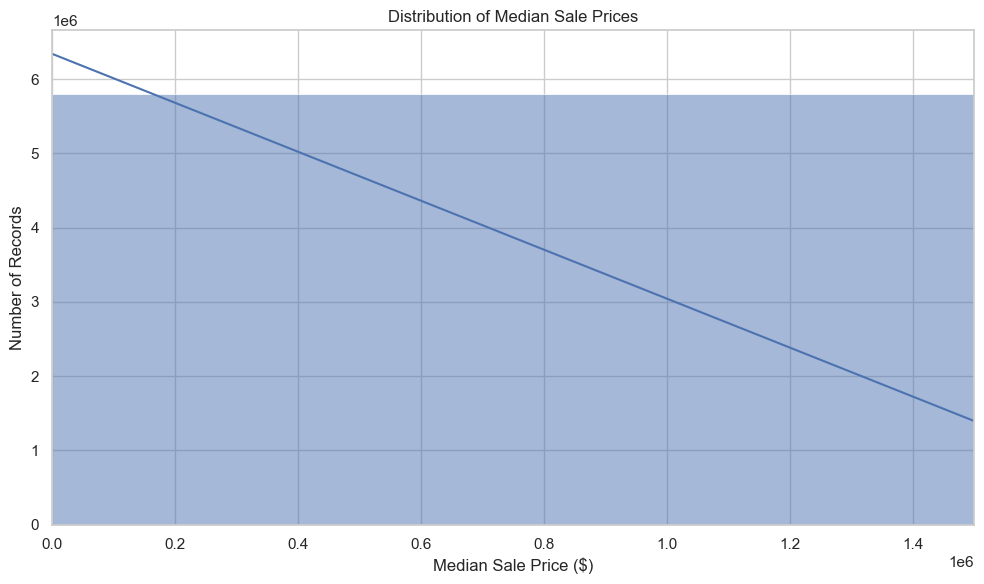

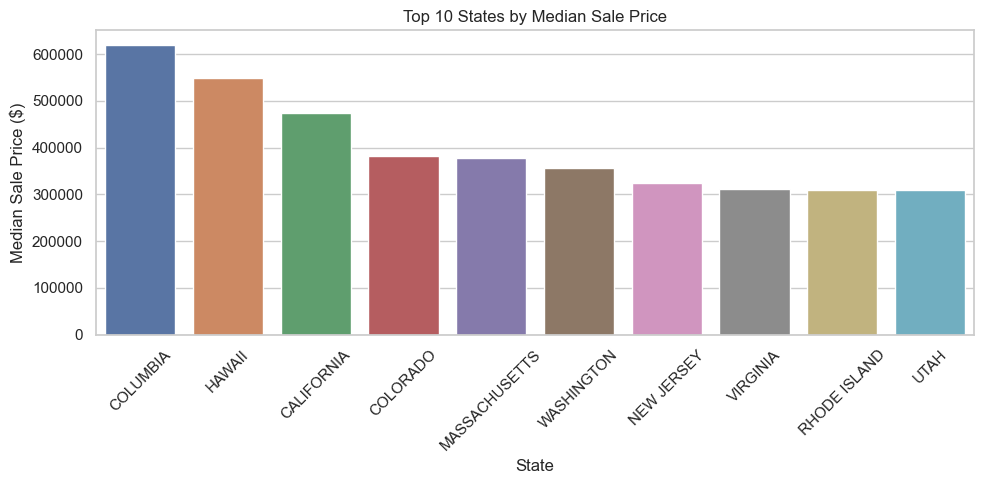

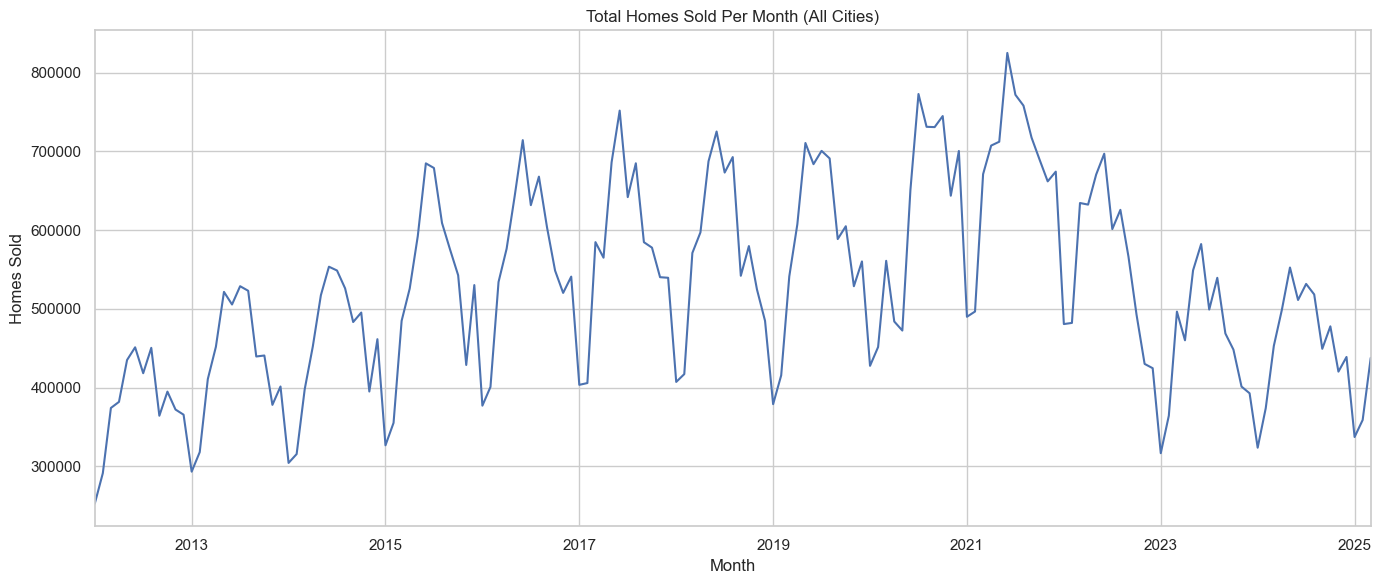

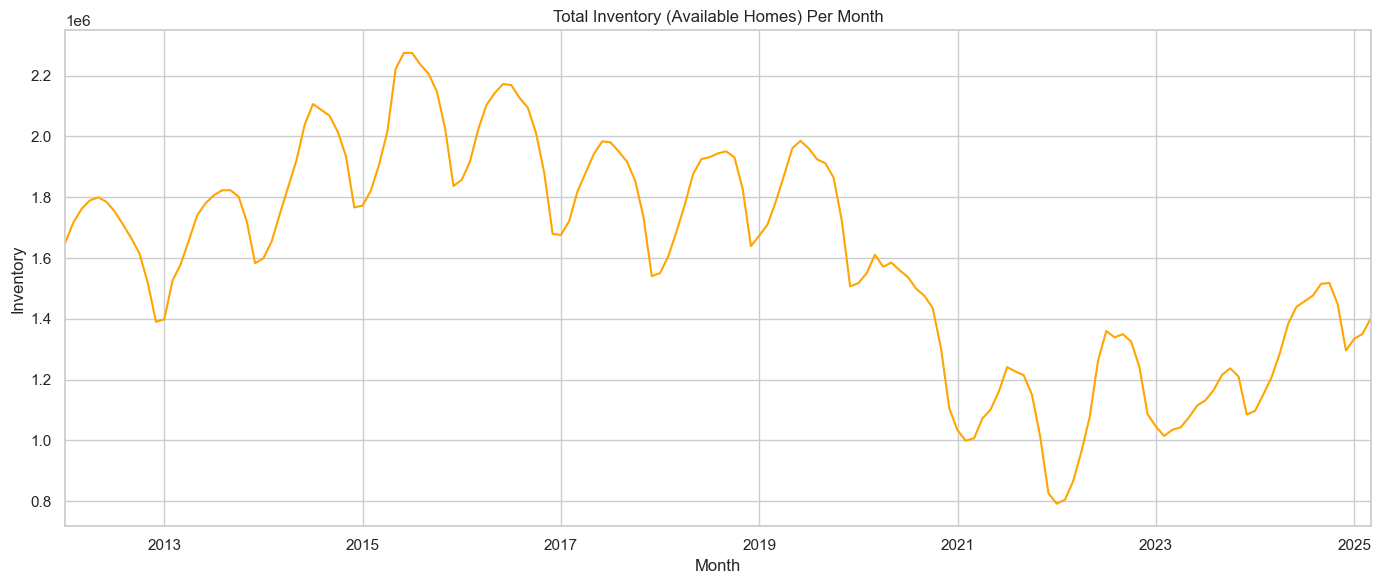

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume your cleaned full data is in:
redfin_df = market_agent.cleaned_data  # (already cleaned by your MarketAgent)

sns.set(style="whitegrid")

# 1. Timeline Range
print("Data covers from", redfin_df['PERIOD_BEGIN'].min(), "to", redfin_df['PERIOD_BEGIN'].max())

# 2. Number of Cities and States
print("\nNumber of unique cities:", redfin_df['CITY'].nunique())
print("Number of unique states:", redfin_df['STATE'].nunique())

# 3. Median Sale Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(redfin_df['MEDIAN_SALE_PRICE'], bins=100, kde=True)
plt.xlim(0, 1_500_000)  # Focus on homes below $1.5M for clarity
plt.title("Distribution of Median Sale Prices")
plt.xlabel("Median Sale Price ($)")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()

# 4. Top 10 States with Highest Median Sale Prices
top_states = (
    redfin_df.groupby('STATE')['MEDIAN_SALE_PRICE']
    .median()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_states.index, y=top_states.values)
plt.title("Top 10 States by Median Sale Price")
plt.xlabel("State")
plt.ylabel("Median Sale Price ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Homes Sold Over Time
homes_sold_monthly = (
    redfin_df.groupby(redfin_df['PERIOD_BEGIN'].dt.to_period('M'))['HOMES_SOLD']
    .sum()
    .to_timestamp()
)

plt.figure(figsize=(14, 6))
homes_sold_monthly.plot()
plt.title("Total Homes Sold Per Month (All Cities)")
plt.xlabel("Month")
plt.ylabel("Homes Sold")
plt.tight_layout()
plt.show()

# 6. Inventory Over Time
inventory_monthly = (
    redfin_df.groupby(redfin_df['PERIOD_BEGIN'].dt.to_period('M'))['INVENTORY']
    .sum()
    .to_timestamp()
)

plt.figure(figsize=(14, 6))
inventory_monthly.plot(color="orange")
plt.title("Total Inventory (Available Homes) Per Month")
plt.xlabel("Month")
plt.ylabel("Inventory")
plt.tight_layout()
plt.show()


### FEMA

In [8]:
import requests
import pandas as pd
import time

class WeatherAgent:
    def __init__(self):
        self.base_url = "https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries"
        self.limit_per_call = 1000
        self.total_records_needed = 20000
        self.sleep_time = 1  # seconds between calls to be polite

    def test_connectivity(self):
        """Test if the FEMA API is reachable from this machine."""
        try:
            print("Testing connection to FEMA API...")
            resp = requests.get(self.base_url, timeout=10)
            print(f"Status code: {resp.status_code}")
            if resp.status_code == 200:
                print("Connection successful.")
                return True
            else:
                print("Received an unexpected status code.")
                return False
        except requests.exceptions.RequestException as e:
            print(f"Connection test failed: {e}")
            return False

    def retrieve_fema_data(self):
        all_records = []
        for skip in range(0, self.total_records_needed, self.limit_per_call):
            params = {
                "$top": self.limit_per_call,
                "$skip": skip,
                "$orderby": "incidentBeginDate desc",  
                "$format": "json"
            }
            print(f"Fetching records {skip} to {skip + self.limit_per_call}...")
            try:
                response = requests.get(self.base_url, params=params, timeout=30)
                response.raise_for_status()
                data = response.json()
                records = data.get('DisasterDeclarationsSummaries', [])
                all_records.extend(records)
            except requests.exceptions.RequestException as e:
                print(f"Request failed at skip={skip}: {e}")
                print("Check your internet connection and DNS settings.")
                break
            time.sleep(self.sleep_time)  # be polite to the API server

        print(f"Total records retrieved: {len(all_records)}")
        return pd.json_normalize(all_records)

    def save_data(self, df, filepath):
        df.to_csv(filepath, index=False)
        print(f"Data saved to {filepath}")

# Instantiate and run
agent = WeatherAgent()
if agent.test_connectivity():
    fema_df = agent.retrieve_fema_data()
    if not fema_df.empty:
        agent.save_data(fema_df, 'fema_data_20000.csv')
else:
    print("Cannot reach FEMA API. Please check your network or DNS settings.")


Testing connection to FEMA API...
Status code: 200
Connection successful.
Fetching records 0 to 1000...
Fetching records 1000 to 2000...
Fetching records 2000 to 3000...
Fetching records 3000 to 4000...
Fetching records 4000 to 5000...
Fetching records 5000 to 6000...
Fetching records 6000 to 7000...
Fetching records 7000 to 8000...
Fetching records 8000 to 9000...
Fetching records 9000 to 10000...
Fetching records 10000 to 11000...
Fetching records 11000 to 12000...
Fetching records 12000 to 13000...
Fetching records 13000 to 14000...
Fetching records 14000 to 15000...
Fetching records 15000 to 16000...
Fetching records 16000 to 17000...
Fetching records 17000 to 18000...
Fetching records 18000 to 19000...
Fetching records 19000 to 20000...
Total records retrieved: 20000
Data saved to fema_data_20000.csv


In [9]:
# Basic Aggregations
disaster_types = fema_df['incidentType'].value_counts().to_dict()
states = fema_df['state'].value_counts().to_dict()
years = pd.to_datetime(fema_df['declarationDate'], errors='coerce').dt.year.value_counts().sort_index().to_dict()

basic_summary = {
    "total_records": len(fema_df),
    "disaster_types": disaster_types,
    "top_states": dict(sorted(states.items(), key=lambda item: item[1], reverse=True)[:10]),  # Top 10 states
    "yearly_declarations": years
}

basic_summary

{'total_records': 20000,
 'disaster_types': {'Biological': 7872,
  'Hurricane': 4157,
  'Severe Storm': 2988,
  'Flood': 1577,
  'Tropical Storm': 1054,
  'Severe Ice Storm': 952,
  'Fire': 621,
  'Tornado': 193,
  'Coastal Storm': 175,
  'Earthquake': 123,
  'Winter Storm': 117,
  'Snowstorm': 87,
  'Mud/Landslide': 34,
  'Typhoon': 24,
  'Other': 16,
  'Dam/Levee Break': 7,
  'Straight-Line Winds': 2,
  'Volcanic Eruption': 1},
 'top_states': {'TX': 1626,
  'FL': 1188,
  'LA': 1169,
  'KY': 1087,
  'NC': 1058,
  'GA': 938,
  'PR': 919,
  'ME': 693,
  'VA': 665,
  'TN': 588},
 'yearly_declarations': {2017: 243,
  2018: 1184,
  2019: 1666,
  2020: 9712,
  2021: 1962,
  2022: 1141,
  2023: 1119,
  2024: 2364,
  2025: 609}}

In [10]:
pip install cohere

DEPRECATION: Loading egg at /Users/soumitra7/anaconda3/lib/python3.11/site-packages/pyBWMD-0.0.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
Note: you may need to restart the kernel to use updated packages.


In [11]:
import cohere

# Initialize Cohere client
co = cohere.Client('xzijvIURu7t7NNRhWLpjhVRNCTt1a1ofbd2Shnds')

questions = [
    "Analyze this FEMA data: 4300 hurricanes, 5000 floods, 3000 tornadoes. What unusual patterns do you see?",
    "Group U.S. states into clusters based on their disaster profiles.",
    "Which three states should prioritize disaster preparedness investments?",
    "Forecast disaster trends for the next 5 years if current patterns continue.",
    "Write a short news article focusing on Texas and including a fictional emergency manager quote.",
    "What risk advice would you give to a new homeowner in Florida?",
    "Create a risk score (out of 10) for California, Florida, and Texas, based on hurricane, flood, and tornado risks."
]

for q in questions:
    response = co.chat(
        model='command-r-plus',
        message=q,
        temperature=0.5,
        max_tokens=500
    )
    print(f"Question: {q}")
    print(f"Answer: {response.text}\n")


Question: Analyze this FEMA data: 4300 hurricanes, 5000 floods, 3000 tornadoes. What unusual patterns do you see?
Answer: The provided FEMA data indicates an unusually high occurrence of natural disasters, specifically hurricanes, floods, and tornadoes, with 4300, 5000, and 3000 incidents respectively. 

Unusual patterns observed in this data include: 

- High Hurricane Frequency: The data suggests an extraordinarily high number of hurricanes, with 4300 incidents. This is significantly higher than the average number of hurricanes making landfall in a typical year. It indicates an increased frequency or a potential change in hurricane behavior, possibly influenced by climate patterns or other factors. 

- Flood Prevalence: With 5000 flood incidents, this data highlights an unusually high occurrence of flooding events. Floods are often a consequence of various factors, including heavy rainfall, storm surges, or river overflow. The high number of floods in this data could be indicative of

Question: Write a short news article focusing on Texas and including a fictional emergency manager quote.
Answer: # Texas Storms: State Braces for More Severe Weather

*By [Your Name]*

**Houston, Texas** – Texans are bracing for another round of severe weather, with forecasts predicting more storms and potential flash flooding across the state. The National Weather Service has issued a series of warnings, urging residents to remain vigilant and prepare for potential disasters.

"We are urging all residents to stay weather-aware and be prepared for any eventuality," said John Doe, the state's emergency manager. "The forecasts indicate we could see multiple hazards, including heavy rainfall, high winds, and the possibility of tornadoes. Our message to Texans is clear: have a plan and stay informed."

The state has already endured a barrage of severe weather in recent weeks, with previous storms causing widespread damage and power outages. With the ground already saturated, officials are

In [12]:
fema_df = pd.read_csv('fema_data_20000.csv')

In [13]:
print(f"Columns: {list(fema_df.columns)}")


Columns: ['femaDeclarationString', 'disasterNumber', 'state', 'declarationType', 'declarationDate', 'fyDeclared', 'incidentType', 'declarationTitle', 'ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared', 'incidentBeginDate', 'incidentEndDate', 'disasterCloseoutDate', 'tribalRequest', 'fipsStateCode', 'fipsCountyCode', 'placeCode', 'designatedArea', 'declarationRequestNumber', 'lastIAFilingDate', 'incidentId', 'region', 'designatedIncidentTypes', 'lastRefresh', 'hash', 'id']


In [14]:
# 1. Clean column names
fema_df.columns = fema_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [15]:
# 2. Fix dates
date_columns = ['declarationdate', 'incidentbegindate', 'incidentenddate']
for col in date_columns:
    fema_df[col] = pd.to_datetime(fema_df[col], errors='coerce')

In [16]:
# How many nulls?
print("\nMissing values:")
print(fema_df.isnull().sum())


Missing values:
femadeclarationstring           0
disasternumber                  0
state                           0
declarationtype                 0
declarationdate                 0
fydeclared                      0
incidenttype                    0
declarationtitle                0
ihprogramdeclared               0
iaprogramdeclared               0
paprogramdeclared               0
hmprogramdeclared               0
incidentbegindate               0
incidentenddate               467
disastercloseoutdate        12825
tribalrequest                   0
fipsstatecode                   0
fipscountycode                  0
placecode                       0
designatedarea                  0
declarationrequestnumber        0
lastiafilingdate            12136
incidentid                      0
region                          0
designatedincidenttypes     15722
lastrefresh                     0
hash                            0
id                              0
dtype: int64


In [17]:
# For now, let's drop rows where incident type or state is missing (critical fields)
fema_df = fema_df.dropna(subset=['incidenttype', 'state'])

In [18]:
# 4. Standardize text fields
fema_df['state'] = fema_df['state'].str.upper().str.strip()
fema_df['incidenttype'] = fema_df['incidenttype'].str.title().str.strip()  # e.g., "Hurricane", "Flood"


In [19]:
# 5. Optional: Keep only useful columns
useful_cols = [
    'disasternumber', 'state', 'incidenttype', 'declarationtype',
    'declarationdate', 'incidentbegindate', 'incidentenddate', 'designatedarea'
]
fema_df_clean = fema_df[useful_cols]


In [20]:
# Final check
print(f"\nCleaned Shape: {fema_df_clean.shape}")
print(fema_df_clean.head())


Cleaned Shape: (20000, 8)
   disasternumber state  incidenttype declarationtype  \
0            5581    NJ          Fire              FM   
1            5580    NC          Fire              FM   
2            5579    NM          Fire              FM   
3            3626    KY  Severe Storm              EM   
4            3626    KY  Severe Storm              EM   

            declarationdate         incidentbegindate incidentenddate  \
0 2025-04-24 00:00:00+00:00 2025-04-22 00:00:00+00:00             NaT   
1 2025-04-20 00:00:00+00:00 2025-04-18 00:00:00+00:00             NaT   
2 2025-04-18 00:00:00+00:00 2025-04-17 00:00:00+00:00             NaT   
3 2025-04-03 00:00:00+00:00 2025-04-02 00:00:00+00:00             NaT   
4 2025-04-03 00:00:00+00:00 2025-04-02 00:00:00+00:00             NaT   

      designatedarea  
0     Ocean (County)  
1     Swain (County)  
2  Valencia (County)  
3   Grayson (County)  
4  Gallatin (County)  


In [21]:
# Save cleaned file
fema_df_clean.to_csv('fema_cleaned.csv', index=False)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

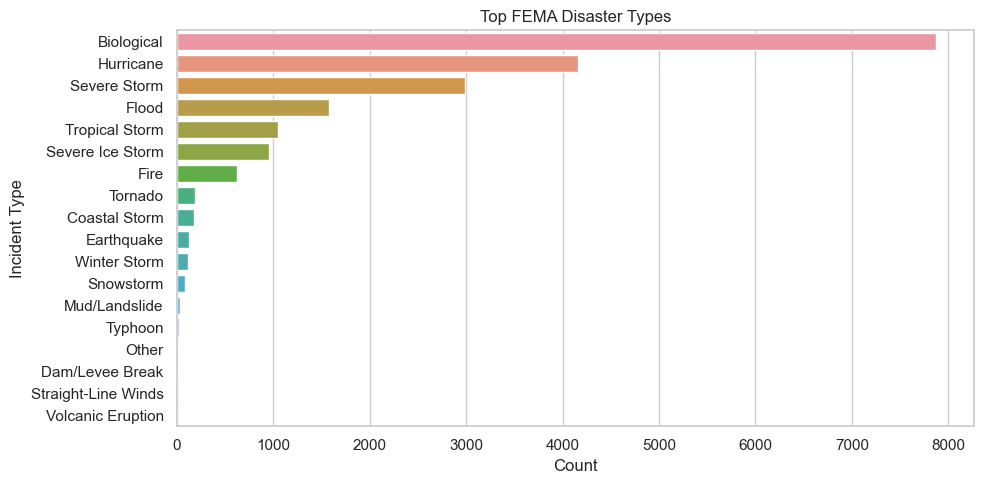

In [23]:
# 1. Most common disaster types
plt.figure(figsize=(10, 5))
sns.countplot(data=fema_df_clean, y='incidenttype', order=fema_df_clean['incidenttype'].value_counts().index)
plt.title("Top FEMA Disaster Types")
plt.xlabel("Count")
plt.ylabel("Incident Type")
plt.tight_layout()
plt.show()

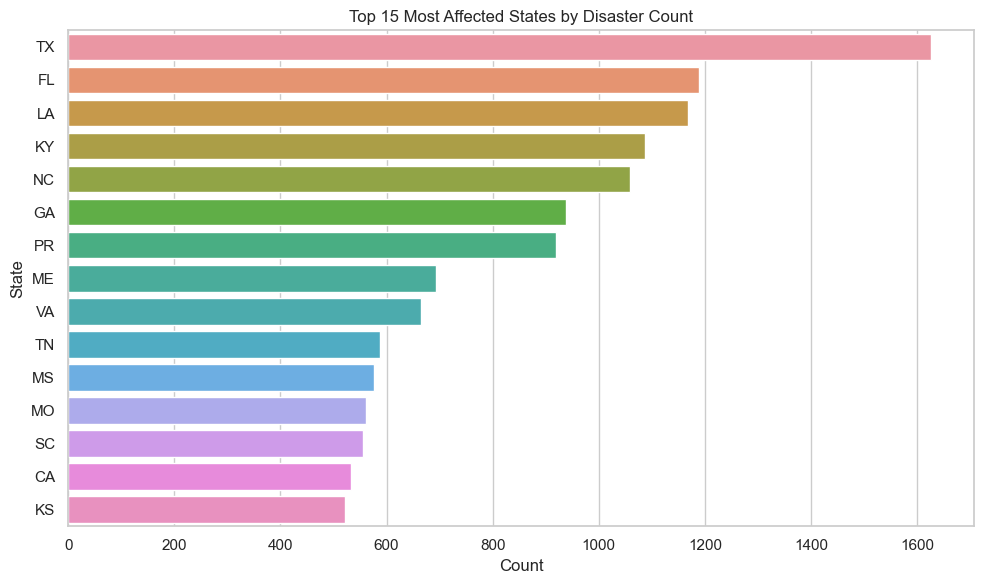

In [24]:

# 2. Most affected states
plt.figure(figsize=(10, 6))
sns.countplot(data=fema_df_clean, y='state', order=fema_df_clean['state'].value_counts().head(15).index)
plt.title("Top 15 Most Affected States by Disaster Count")
plt.xlabel("Count")
plt.ylabel("State")
plt.tight_layout()
plt.show()


/var/folders/1n/jwf7cym1789ghbzgwdcxd1140000gn/T/ipykernel_64552/2486978576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fema_df_clean['year'] = fema_df_clean['declarationdate'].dt.year
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


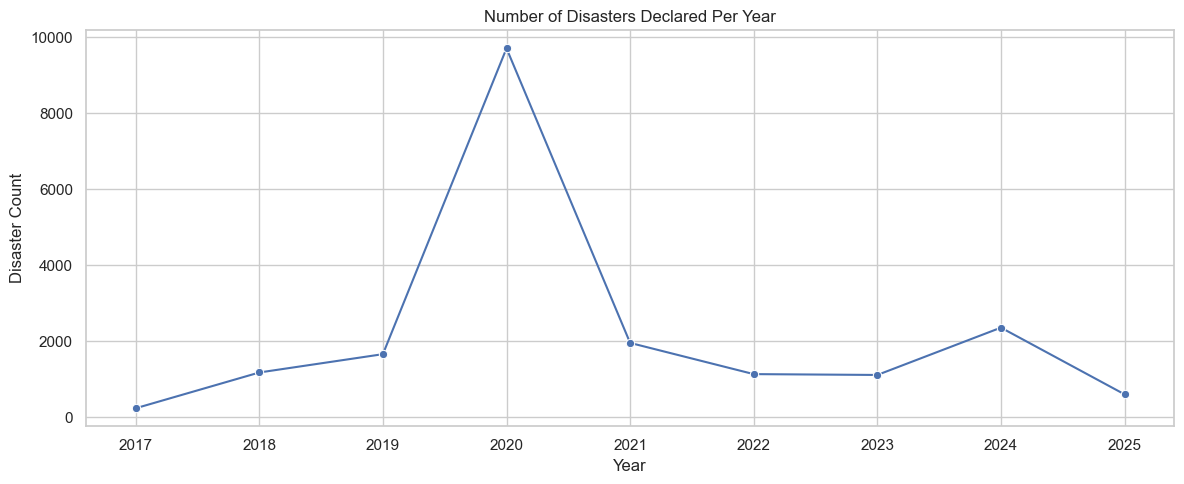

In [25]:

# 3. Disaster declarations over years
fema_df_clean['year'] = fema_df_clean['declarationdate'].dt.year
yearly = fema_df_clean['year'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.lineplot(x=yearly.index, y=yearly.values, marker='o')
plt.title("Number of Disasters Declared Per Year")
plt.xlabel("Year")
plt.ylabel("Disaster Count")
plt.tight_layout()
plt.show()


/var/folders/1n/jwf7cym1789ghbzgwdcxd1140000gn/T/ipykernel_64552/4202798043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fema_df_clean['duration'] = (fema_df_clean['incidentenddate'] - fema_df_clean['incidentbegindate']).dt.days
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


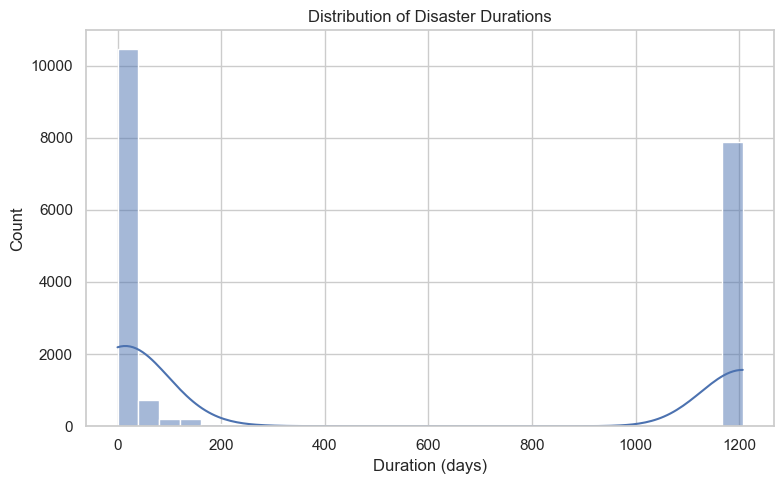

In [26]:

# 4. Average disaster duration (days)
fema_df_clean['duration'] = (fema_df_clean['incidentenddate'] - fema_df_clean['incidentbegindate']).dt.days
plt.figure(figsize=(8, 5))
sns.histplot(fema_df_clean['duration'].dropna(), bins=30, kde=True)
plt.title("Distribution of Disaster Durations")
plt.xlabel("Duration (days)")
plt.tight_layout()
plt.show()


In [27]:
# Calculate duration (in days)
fema_df_clean['duration_days'] = (
    fema_df_clean['incidentenddate'] - fema_df_clean['incidentbegindate']
).dt.days

# Drop NaNs or negative durations
fema_df_clean_valid = fema_df_clean.dropna(subset=['duration_days'])
fema_df_clean_valid = fema_df_clean_valid[fema_df_clean_valid['duration_days'] >= 0]

# Get the top 5 longest disasters
longest_disasters = fema_df_clean_valid.sort_values(by='duration_days', ascending=False).head(5)

# Show the results
longest_disasters[['disasternumber', 'incidenttype', 'state', 'incidentbegindate', 'incidentenddate', 'duration_days']]


/var/folders/1n/jwf7cym1789ghbzgwdcxd1140000gn/T/ipykernel_64552/3467268623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fema_df_clean['duration_days'] = (


,disasternumber,incidenttype,state,incidentbegindate,incidentenddate,duration_days
10206,4501,Biological,GA,2020-01-20 00:00:00+00:00,2023-05-11 00:00:00+00:00,1207.0
11771,4522,Biological,ME,2020-01-20 00:00:00+00:00,2023-05-11 00:00:00+00:00,1207.0
11757,4522,Biological,ME,2020-01-20 00:00:00+00:00,2023-05-11 00:00:00+00:00,1207.0
11758,4522,Biological,ME,2020-01-20 00:00:00+00:00,2023-05-11 00:00:00+00:00,1207.0
11759,4522,Biological,ME,2020-01-20 00:00:00+00:00,2023-05-11 00:00:00+00:00,1207.0


FEMA Classifies "Biological" Disasters As:
- Epidemics

- Pandemics

- Animal-borne diseases

- Insect-borne diseases

- Bioterrorism events

- Plant diseases impacting agriculture significantly

### Data Merging

In [28]:
class RiskAgent:
    def __init__(self, fema_df, redfin_csv_path):
        self.fema_df = fema_df.copy()
        self.redfin_csv_path = redfin_csv_path
        self.redfin_df = None
        self.merged_df = None

    # 1. Load Redfin Data
    def load_redfin_data(self):
        print("Loading Redfin data...")
        self.redfin_df = pd.read_csv(self.redfin_csv_path)
        print(f"Redfin data shape: {self.redfin_df.shape}")

    # 2. Prepare FEMA Data
    def prepare_fema_data(self):
        print("Preparing FEMA data...")
        self.fema_df['incidentbegindate'] = pd.to_datetime(self.fema_df['incidentbegindate'], errors='coerce')
        self.fema_df['YEAR'] = self.fema_df['incidentbegindate'].dt.year
        self.fema_df['state'] = self.fema_df['state'].str.upper().str.strip()

    # 3. Prepare Redfin Data
    def prepare_redfin_data(self):
        print("Preparing Redfin data...")
        self.redfin_df['PERIOD_BEGIN'] = pd.to_datetime(self.redfin_df['PERIOD_BEGIN'], errors='coerce')
        self.redfin_df['YEAR'] = self.redfin_df['PERIOD_BEGIN'].dt.year
        self.redfin_df['STATE'] = self.redfin_df['STATE'].str.upper().str.strip()
        # Important: Use STATE_CODE if needed (match FEMA state)
        if 'STATE_CODE' in self.redfin_df.columns:
            self.redfin_df['STATE_CODE'] = self.redfin_df['STATE_CODE'].str.upper().str.strip()
        else:
            print("Warning: STATE_CODE column not found in Redfin data.")

    # 4. Aggregate FEMA Disaster Counts
    def aggregate_fema_disasters(self):
        print("Aggregating FEMA disasters by State-Year...")
        self.fema_state_year = (
            self.fema_df.groupby(['state', 'YEAR'])
            .size()
            .reset_index(name='fema_disaster_count')
        )
        print(f"FEMA aggregated data shape: {self.fema_state_year.shape}")

    # 5. Merge FEMA + Redfin
    def merge_datasets(self):
        print("Merging FEMA and Redfin datasets...")
        if 'STATE_CODE' in self.redfin_df.columns:
            left_merge_key = 'STATE_CODE'
        else:
            left_merge_key = 'STATE'
        
        self.merged_df = self.redfin_df.merge(
            self.fema_state_year,
            left_on=[left_merge_key, 'YEAR'],
            right_on=['state', 'YEAR'],
            how='left'
        )
        self.merged_df['fema_disaster_count'] = self.merged_df['fema_disaster_count'].fillna(0)
        self.merged_df = self.merged_df.drop(columns=['state'])  # Drop redundant column
        print(f"Merged data shape: {self.merged_df.shape}")

    # 6. Save Merged Data
    def save_merged_data(self, filepath):
        if self.merged_df is not None:
            self.merged_df.to_csv(filepath, index=False)
            print(f"Saved merged FEMA-Redfin data to {filepath}")
        else:
            print("No merged data to save.")

    # 7. Get the merged data
    def get_merged_data(self):
        return self.merged_df


In [29]:
# Create RiskAgent instance
risk_agent = RiskAgent(fema_df=fema_df_clean, redfin_csv_path='redfin_city_sample_cleaned.csv')

# Step-by-step:
risk_agent.load_redfin_data()
risk_agent.prepare_fema_data()
risk_agent.prepare_redfin_data()
risk_agent.aggregate_fema_disasters()
risk_agent.merge_datasets()

# Save final merged data
risk_agent.save_merged_data('merged_fema_redfin_dataset.csv')

# Get merged DataFrame
merged_df = risk_agent.get_merged_data()

# View the first few rows
merged_df.head()


Loading Redfin data...
Redfin data shape: (5812149, 55)
Preparing FEMA data...
Preparing Redfin data...
Aggregating FEMA disasters by State-Year...
FEMA aggregated data shape: (334, 3)
Merging FEMA and Redfin datasets...
Merged data shape: (5812149, 57)
Saved merged FEMA-Redfin data to merged_fema_redfin_dataset.csv


,PERIOD_BEGIN,PERIOD_END,PERIOD_DURATION,REGION_TYPE,IS_SEASONALLY_ADJUSTED,REGION,CITY,STATE,STATE_CODE,PROPERTY_TYPE,...,PRICE_DROPS_MOM,PRICE_DROPS_YOY,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,PARENT_METRO_REGION,PARENT_METRO_REGION_METRO_CODE,LAST_UPDATED,YEAR,fema_disaster_count
0,2015-10-01,2015-10-31,30,place,False,"Indian Trail, NC",Indian Trail,NORTH CAROLINA,NC,Single Family Residential,...,-0.011228,0.023309,0.291667,-0.084804,0.034524,"Charlotte, NC",16740,2025-04-18 14:40:47.550 Z,2015,0.0
1,2014-04-01,2014-04-30,30,place,False,"Hainesville, IL",Hainesville,ILLINOIS,IL,Condo/Co-op,...,0.166667,0.000000,0.000000,0.000000,0.000000,"Lake County, IL",29404,2025-04-18 14:40:47.550 Z,2014,0.0
2,2017-10-01,2017-10-31,30,place,False,"Maysville, NC",Maysville,NORTH CAROLINA,NC,All Residential,...,0.000000,0.000000,0.000000,0.000000,0.000000,"New Bern, NC",35100,2025-04-18 14:40:47.550 Z,2017,0.0
3,2024-07-01,2024-07-31,30,place,False,"Chewelah, WA",Chewelah,WASHINGTON,WA,Single Family Residential,...,-0.057692,-0.659091,0.500000,-0.166667,0.277778,"Spokane, WA",44060,2025-04-18 14:40:47.550 Z,2024,27.0
4,2022-01-01,2022-01-31,30,place,False,"Lombard, IL",Lombard,ILLINOIS,IL,Single Family Residential,...,-0.028175,-0.280019,0.241379,-0.175287,-0.136398,"Chicago, IL",16984,2025-04-18 14:40:47.550 Z,2022,1.0


The RiskAgent is responsible for preparing, cleaning, and combining the FEMA disaster data and Redfin real estate market data.
Its goal is to correctly link the number of disasters in a state to the housing market conditions in that same state and same year.

By doing this, we can later study how disaster activity might influence home prices, sales, inventory, and other important real estate metrics.

The RiskAgent carefully:

- Loads and prepares the FEMA and Redfin datasets.

- Creates a YEAR column in both datasets.

- Counts the number of disasters in each state-year.

- Merges the datasets using both state and year together.

- Fills in zeros for any state-year where no disasters happened.

This way, every housing record is matched to the correct level of disaster activity happening at the same time and location.

In [30]:
# Datatype information
merged_df.info()

# Missing values
missing = merged_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("\n Missing Values:")
print(missing)

# Basic Statistics
print("\n Summary Statistics:")
print(merged_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5812149 entries, 0 to 5812148
Data columns (total 57 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   PERIOD_BEGIN                    datetime64[ns]
 1   PERIOD_END                      object        
 2   PERIOD_DURATION                 int64         
 3   REGION_TYPE                     object        
 4   IS_SEASONALLY_ADJUSTED          bool          
 5   REGION                          object        
 6   CITY                            object        
 7   STATE                           object        
 8   STATE_CODE                      object        
 9   PROPERTY_TYPE                   object        
 10  MEDIAN_SALE_PRICE               float64       
 11  MEDIAN_SALE_PRICE_MOM           float64       
 12  MEDIAN_SALE_PRICE_YOY           float64       
 13  MEDIAN_LIST_PRICE               float64       
 14  MEDIAN_LIST_PRICE_MOM           float64       
 15

In [31]:
# If any important numeric fields are still NaN, fill with 0
important_cols = ['MEDIAN_LIST_PRICE', 'NEW_LISTINGS', 'INVENTORY', 'PRICE_DROPS','MEDIAN_LIST_PPSF']
for col in important_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(0)

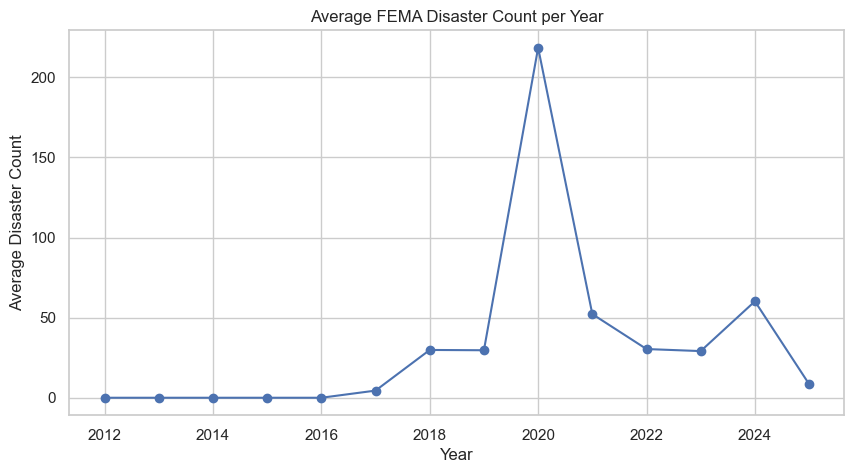

In [32]:
disasters_per_year = (
    merged_df.groupby('YEAR')['fema_disaster_count']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(disasters_per_year['YEAR'], disasters_per_year['fema_disaster_count'], marker='o')
plt.title('Average FEMA Disaster Count per Year')
plt.xlabel('Year')
plt.ylabel('Average Disaster Count')
plt.grid(True)
plt.show()

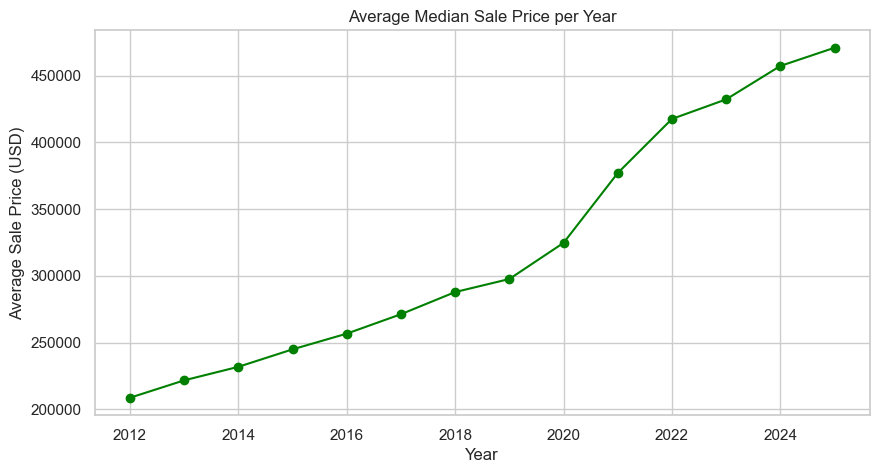

In [33]:
housing_prices_per_year = (
    merged_df.groupby('YEAR')['MEDIAN_SALE_PRICE']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(housing_prices_per_year['YEAR'], housing_prices_per_year['MEDIAN_SALE_PRICE'], color='green', marker='o')
plt.title('Average Median Sale Price per Year')
plt.xlabel('Year')
plt.ylabel('Average Sale Price (USD)')
plt.grid(True)
plt.show()

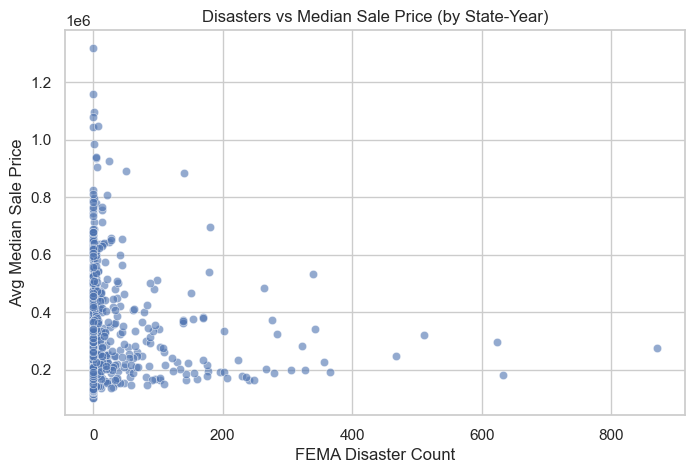

In [34]:
# Group by state-year and take mean of prices + disasters
grouped = (
    merged_df
    .groupby(['STATE', 'YEAR'])
    .agg({
        'fema_disaster_count': 'first',
        'MEDIAN_SALE_PRICE': 'mean'
    })
    .reset_index()
)

# Plot updated
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='fema_disaster_count',
    y='MEDIAN_SALE_PRICE',
    data=grouped,
    alpha=0.6
)
plt.title('Disasters vs Median Sale Price (by State-Year)')
plt.xlabel('FEMA Disaster Count')
plt.ylabel('Avg Median Sale Price')
plt.grid(True)
plt.show()


- Most state-years had low disaster counts (left side) and variable housing prices.

- As disaster count increases (right side), there's a slight decline or flattening in average home prices.

- A few state-years had extremely high disaster counts (>600) — but still didn’t reach high prices.

- The top-left cluster shows high home prices where disaster count is low.

/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


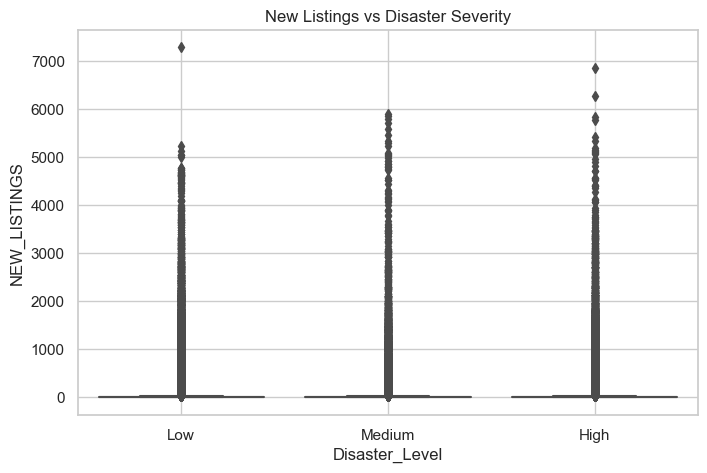

In [35]:
# Bucket disaster levels
merged_df['YEAR'] = pd.to_datetime(merged_df['PERIOD_BEGIN'], errors='coerce').dt.year
merged_df['Disaster_Level'] = pd.cut(
    merged_df['fema_disaster_count'],
    bins=[-1, 5, 20, 1000],
    labels=['Low', 'Medium', 'High']
)

# Compare average new listings by disaster group
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='Disaster_Level', y='NEW_LISTINGS')
plt.title("New Listings vs Disaster Severity")
plt.grid(True)
plt.show()


- Median new listings don’t drastically shift between Low, Medium, or High disaster years.

- This suggests new listings are not very sensitive to disaster frequency at a broad level.

/var/folders/1n/jwf7cym1789ghbzgwdcxd1140000gn/T/ipykernel_64552/3744437286.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby('Disaster_Bin')['HOMES_SOLD']
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


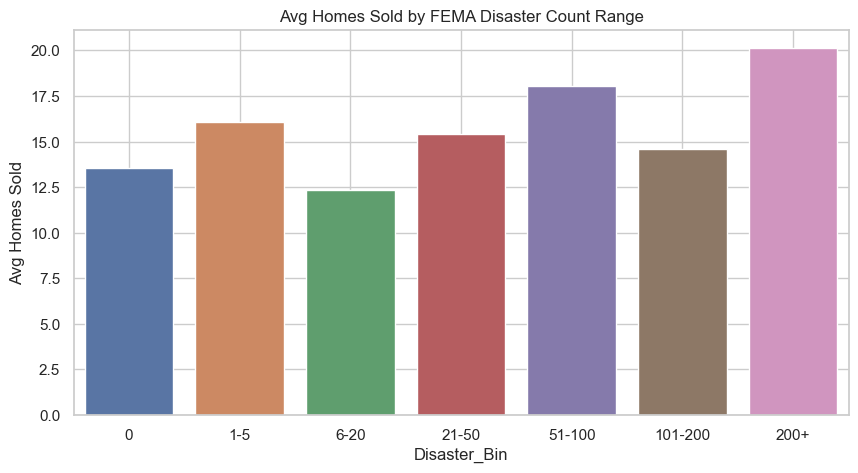

In [36]:
# Bin disaster counts
merged_df['Disaster_Bin'] = pd.cut(
    merged_df['fema_disaster_count'],
    bins=[-1, 0, 5, 20, 50, 100, 200, 1000],
    labels=['0', '1-5', '6-20', '21-50', '51-100', '101-200', '200+']
)

# Average homes sold by disaster bin
homes_sold_by_disaster = (
    merged_df.groupby('Disaster_Bin')['HOMES_SOLD']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=homes_sold_by_disaster, x='Disaster_Bin', y='HOMES_SOLD')
plt.title("Avg Homes Sold by FEMA Disaster Count Range")
plt.ylabel("Avg Homes Sold")
plt.grid(True)
plt.show()


In [37]:
!pip install sdv


In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm

# Load city disaster data
city_disaster = pd.read_csv('City_Natural_Disaster_Score__0_30_realistic_.csv')
unique_cities = city_disaster[['STATE', 'CITY', 'natural_disaster_score']].drop_duplicates()

# Set date range: past three years, daily
start_date = datetime(2022, 5, 3)
end_date = datetime(2025, 5, 2)  # inclusive
total_days = (end_date - start_date).days + 1
timestamps = [start_date + timedelta(days=d) for d in range(total_days)]

def generate_weather(city, state, disaster_score):
    # Base values influenced by disaster score
    base_temp = 70 - disaster_score * 0.7
    temp_range = 20 + disaster_score * 0.5
    base_wind = 8 + disaster_score * 0.3
    base_precip = disaster_score * 0.08 * 24  # Convert hourly to daily total
    base_humidity = 60 + disaster_score * 0.6

    city_data = []
    for ts in timestamps:
        day_of_year = ts.timetuple().tm_yday
        # Seasonal variation
        season_adj = 10 * np.sin((2 * np.pi * (day_of_year - 172)) / 365.25)
        # Daily temp (average for the day)
        temp = base_temp + temp_range * 0.5 + season_adj + np.random.normal(0, 1.5)
        
        city_data.append({
            'state': state,
            'city': city,
            'date': ts.date(),
            'avg_temp': round(temp, 1),
            'min_temp': round(temp - np.random.uniform(2,4), 1),
            'max_temp': round(temp + np.random.uniform(2,4), 1),
            'wind_speed': round(base_wind + np.random.normal(0, 1.2), 1),
            'precipitation': round(max(0, base_precip + np.random.normal(0, 0.5)), 2),
            'humidity': round(base_humidity + np.random.normal(0, 5), 1),
            'pressure': round(1013 + np.random.normal(0, 2), 1),
            'disaster_score': disaster_score
        })
    return city_data

# Generate and save data in chunks
chunk_size = 5  # Adjust based on memory
all_city_indices = list(unique_cities.index)

for i in tqdm(range(0, len(all_city_indices), chunk_size)):
    chunk_indices = all_city_indices[i:i+chunk_size]
    weather_data = []
    for idx in chunk_indices:
        row = unique_cities.loc[idx]
        weather_data.extend(generate_weather(row['CITY'], row['STATE'], row['natural_disaster_score']))
    
    weather_df = pd.DataFrame(weather_data)
    if i == 0:
        weather_df.to_csv('synthetic_noaa_daily_precipitation.csv', index=False, mode='w')
    else:
        weather_df.to_csv('synthetic_noaa_daily_precipitation.csv', index=False, header=False, mode='a')

100%|███████████████████████████████████████| 4591/4591 [08:25<00:00,  9.08it/s]


In [44]:
# Merge logic (same as you have)
merged_df = pd.read_csv("merged_fema_redfin_dataset.csv")
disaster_scores = pd.read_csv("City_Natural_Disaster_Score__0_30_realistic_.csv")

merged_df['CITY'] = merged_df['CITY'].astype(str).str.title().str.strip()
merged_df['STATE'] = merged_df['STATE'].astype(str).str.upper().str.strip()
disaster_scores['CITY'] = disaster_scores['CITY'].astype(str).str.title().str.strip()
disaster_scores['STATE'] = disaster_scores['STATE'].astype(str).str.upper().str.strip()

merged_result = pd.merge(merged_df, disaster_scores, on=['STATE', 'CITY'], how='left')

#  Save to Downloads
merged_result.to_csv("redfin_with_disaster_score.csv", index=False)

print(" File saved to ~/Downloads/redfin_with_disaster_score.csv")

 File saved to ~/Downloads/redfin_with_disaster_score.csv


In [45]:
import pandas as pd

In [43]:
import pandas as pd

# Step 1: Load NOAA daily data
noaa_df = pd.read_csv("synthetic_noaa_daily_precipitation.csv")
noaa_df['date'] = pd.to_datetime(noaa_df['date'], errors='coerce')
noaa_df['YEAR'] = noaa_df['date'].dt.year
noaa_df['MONTH'] = noaa_df['date'].dt.month
noaa_df['STATE'] = noaa_df['state'].str.upper().str.strip()
noaa_df['CITY'] = noaa_df['city'].str.title().str.strip()

# Step 2: Aggregate NOAA to monthly per city-state
noaa_monthly = noaa_df.groupby(['STATE', 'CITY', 'YEAR', 'MONTH']).agg({
    'avg_temp': 'mean',
    'min_temp': 'mean',
    'max_temp': 'mean',
    'wind_speed': 'mean',
    'precipitation': 'sum',
    'humidity': 'mean',
    'pressure': 'mean',
    'disaster_score': 'mean',
    'date': 'count'  # number of records contributing
}).reset_index().rename(columns={'date': 'source_count'})

print(f"NOAA monthly shape: {noaa_monthly.shape}")
print(noaa_monthly.head())

# Step 3: Load Redfin monthly data
redfin_df = pd.read_csv("redfin_with_disaster_score.csv")
redfin_df['PERIOD_BEGIN'] = pd.to_datetime(redfin_df['PERIOD_BEGIN'], errors='coerce')
redfin_df['YEAR'] = redfin_df['PERIOD_BEGIN'].dt.year
redfin_df['MONTH'] = redfin_df['PERIOD_BEGIN'].dt.month
redfin_df['STATE'] = redfin_df['STATE'].str.upper().str.strip()
redfin_df['CITY'] = redfin_df['CITY'].str.title().str.strip()

print(f"Redfin shape: {redfin_df.shape}")

# Step 4: Merge Redfin with NOAA monthly data
merged_df = pd.merge(
    redfin_df,
    noaa_monthly,
    on=['STATE', 'CITY', 'YEAR', 'MONTH'],
    how='left'
)

print("Merged data sample:")
print(merged_df[['CITY', 'STATE', 'YEAR', 'MONTH', 'MEDIAN_SALE_PRICE', 'avg_temp', 'disaster_score', 'source_count']].head())

# Step 5: Save output
merged_df.to_csv("redfin_with_fema_noaa.csv", index=False)
print(" Merged dataset saved to redfin_with_fema_noaa.csv")

NOAA monthly shape: (849187, 13)
     STATE    CITY  YEAR  MONTH   avg_temp   min_temp   max_temp  wind_speed  \
0  ALABAMA  Abanda  2022      5  64.413793  61.237931  67.417241   14.341379   
1  ALABAMA  Abanda  2022      6  69.060000  66.166667  72.136667   14.730000   
2  ALABAMA  Abanda  2022      7  74.012903  70.906452  77.087097   14.845161   
3  ALABAMA  Abanda  2022      8  78.529032  75.567742  81.516129   14.525806   
4  ALABAMA  Abanda  2022      9  79.793333  76.810000  82.960000   14.503333   

   precipitation   humidity     pressure  disaster_score  source_count  
0        1225.85  73.148276  1013.296552            22.0            29  
1        1267.12  72.440000  1013.686667            22.0            30  
2        1304.95  74.451613  1012.306452            22.0            31  
3        1313.46  71.922581  1013.487097            22.0            31  
4        1268.69  76.256667  1012.840000            22.0            30  
Redfin shape: (5812149, 59)
Merged data sample:


In [1]:
import pandas as pd
df = pd.read_csv('redfin_with_fema_noaa_cleaned.csv')
print(df.columns.tolist())


/Users/soumitra7/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


['PERIOD_BEGIN', 'PERIOD_END', 'PERIOD_DURATION', 'REGION_TYPE', 'IS_SEASONALLY_ADJUSTED', 'REGION', 'CITY', 'STATE', 'STATE_CODE', 'PROPERTY_TYPE', 'MEDIAN_SALE_PRICE', 'MEDIAN_SALE_PRICE_MOM', 'MEDIAN_SALE_PRICE_YOY', 'MEDIAN_LIST_PRICE', 'MEDIAN_LIST_PRICE_MOM', 'MEDIAN_LIST_PRICE_YOY', 'MEDIAN_PPSF', 'MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF', 'MEDIAN_LIST_PPSF_MOM', 'MEDIAN_LIST_PPSF_YOY', 'HOMES_SOLD', 'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES', 'PENDING_SALES_MOM', 'PENDING_SALES_YOY', 'NEW_LISTINGS', 'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'INVENTORY', 'INVENTORY_MOM', 'INVENTORY_YOY', 'MONTHS_OF_SUPPLY', 'MONTHS_OF_SUPPLY_MOM', 'MONTHS_OF_SUPPLY_YOY', 'MEDIAN_DOM', 'MEDIAN_DOM_MOM', 'MEDIAN_DOM_YOY', 'AVG_SALE_TO_LIST', 'AVG_SALE_TO_LIST_MOM', 'AVG_SALE_TO_LIST_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM', 'SOLD_ABOVE_LIST_YOY', 'PRICE_DROPS', 'PRICE_DROPS_MOM', 'PRICE_DROPS_YOY', 'OFF_MARKET_IN_TWO_WEEKS', 'OFF_MARKET_IN_TWO_WEEKS_MOM', 'OFF_MARKET_IN

In [2]:
import pandas as pd

def clean_merged_data(input_path, output_path):
    # Load merged dataset
    df = pd.read_csv(input_path)
    
    print("Initial null value counts:")
    print(df.isnull().sum())

    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Fill numeric columns with median
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Filled {col} with median: {median_val:.2f}")

    # Fill categorical columns with mode or 'Unknown'
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()
            if not mode_val.empty:
                df[col] = df[col].fillna(mode_val[0])
                print(f"Filled {col} with mode: {mode_val[0]}")
            else:
                df[col] = df[col].fillna('Unknown')
                print(f"Filled {col} with 'Unknown'")

    # Validate
    print("\nPost-cleaning null counts:")
    print(df.isnull().sum())

    # Save cleaned data
    df.to_csv(output_path, index=False)
    print(f"\n Cleaned data saved to {output_path}")

# Usage
clean_merged_data(
    input_path="redfin_with_fema_noaa.csv",
    output_path="redfin_with_fema_noaa_cleaned.csv"
)


Initial null value counts:
PERIOD_BEGIN                    0
PERIOD_END                      0
PERIOD_DURATION                 0
REGION_TYPE                     0
IS_SEASONALLY_ADJUSTED          0
                           ...   
precipitation             4488408
humidity                  4488408
pressure                  4488408
disaster_score            4488408
source_count              4488408
Length: 68, dtype: int64
Filled MEDIAN_LIST_PRICE with median: 254000.00
Filled MEDIAN_LIST_PPSF with median: 144.64
Filled PRICE_DROPS with median: 0.24
Filled avg_temp with median: 74.03
Filled min_temp with median: 71.03
Filled max_temp with median: 77.03
Filled wind_speed with median: 11.86
Filled precipitation with median: 750.17
Filled humidity with median: 67.82
Filled pressure with median: 1013.00
Filled disaster_score with median: 13.00
Filled source_count with median: 31.00

Post-cleaning null counts:
PERIOD_BEGIN              0
PERIOD_END                0
PERIOD_DURATION           

In [3]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("redfin_with_fema_noaa_cleaned.csv")

# Print all column names
print(df.columns.tolist())


['PERIOD_BEGIN', 'PERIOD_END', 'PERIOD_DURATION', 'REGION_TYPE', 'IS_SEASONALLY_ADJUSTED', 'REGION', 'CITY', 'STATE', 'STATE_CODE', 'PROPERTY_TYPE', 'MEDIAN_SALE_PRICE', 'MEDIAN_SALE_PRICE_MOM', 'MEDIAN_SALE_PRICE_YOY', 'MEDIAN_LIST_PRICE', 'MEDIAN_LIST_PRICE_MOM', 'MEDIAN_LIST_PRICE_YOY', 'MEDIAN_PPSF', 'MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF', 'MEDIAN_LIST_PPSF_MOM', 'MEDIAN_LIST_PPSF_YOY', 'HOMES_SOLD', 'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES', 'PENDING_SALES_MOM', 'PENDING_SALES_YOY', 'NEW_LISTINGS', 'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'INVENTORY', 'INVENTORY_MOM', 'INVENTORY_YOY', 'MONTHS_OF_SUPPLY', 'MONTHS_OF_SUPPLY_MOM', 'MONTHS_OF_SUPPLY_YOY', 'MEDIAN_DOM', 'MEDIAN_DOM_MOM', 'MEDIAN_DOM_YOY', 'AVG_SALE_TO_LIST', 'AVG_SALE_TO_LIST_MOM', 'AVG_SALE_TO_LIST_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM', 'SOLD_ABOVE_LIST_YOY', 'PRICE_DROPS', 'PRICE_DROPS_MOM', 'PRICE_DROPS_YOY', 'OFF_MARKET_IN_TWO_WEEKS', 'OFF_MARKET_IN_TWO_WEEKS_MOM', 'OFF_MARKET_IN

In [5]:
numerical_cols = [
    'MEDIAN_SALE_PRICE', 'MEDIAN_LIST_PRICE', 'MEDIAN_PPSF', 'HOMES_SOLD',
    'NEW_LISTINGS', 'INVENTORY', 'MEDIAN_DOM', 'fema_disaster_count', 'natural_disaster_score'
]

print(df[numerical_cols].describe())



       MEDIAN_SALE_PRICE  MEDIAN_LIST_PRICE    MEDIAN_PPSF    HOMES_SOLD  \
count       5.812100e+04       5.812100e+04   58121.000000  58121.000000   
mean        3.165353e+05       3.365600e+05     185.926570     14.222484   
std         3.916626e+05       4.772386e+05    1708.466840     53.156784   
min         1.000000e+00       9.250000e+02       0.000000      1.000000   
25%         1.350000e+05       1.750000e+05      85.339494      1.000000   
50%         2.250000e+05       2.540000e+05     131.182796      4.000000   
75%         3.700150e+05       3.680000e+05     204.644097     11.000000   
max         1.725000e+07       5.300000e+07  262000.000000   2851.000000   

       NEW_LISTINGS     INVENTORY    MEDIAN_DOM  fema_disaster_count  \
count  58121.000000  58121.000000  58121.000000         58121.000000   
mean      16.338071     43.302404     96.441906            37.051634   
std       62.394822    170.350313    209.152693            93.228159   
min        0.000000      0.

/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


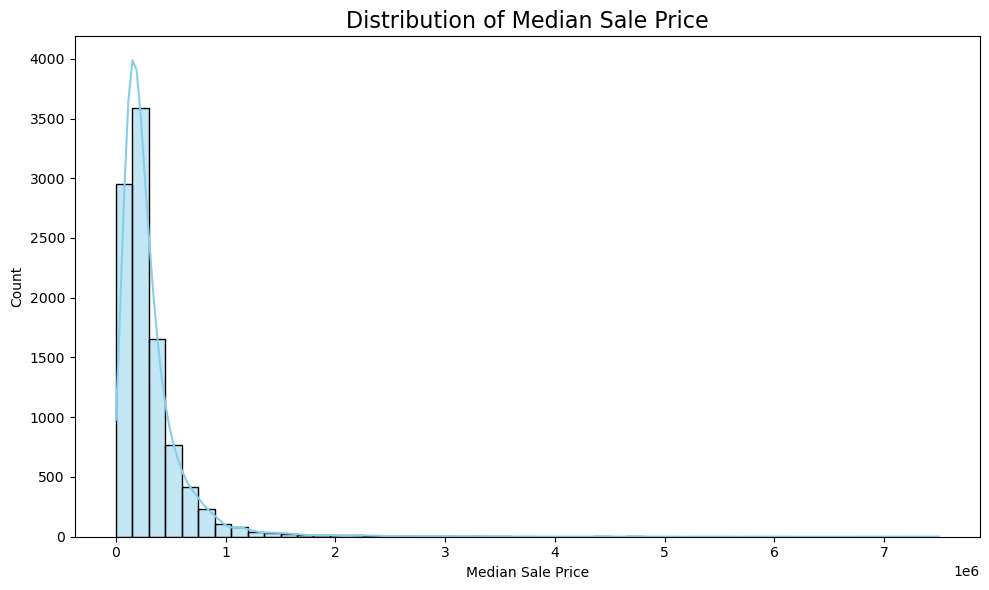

/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


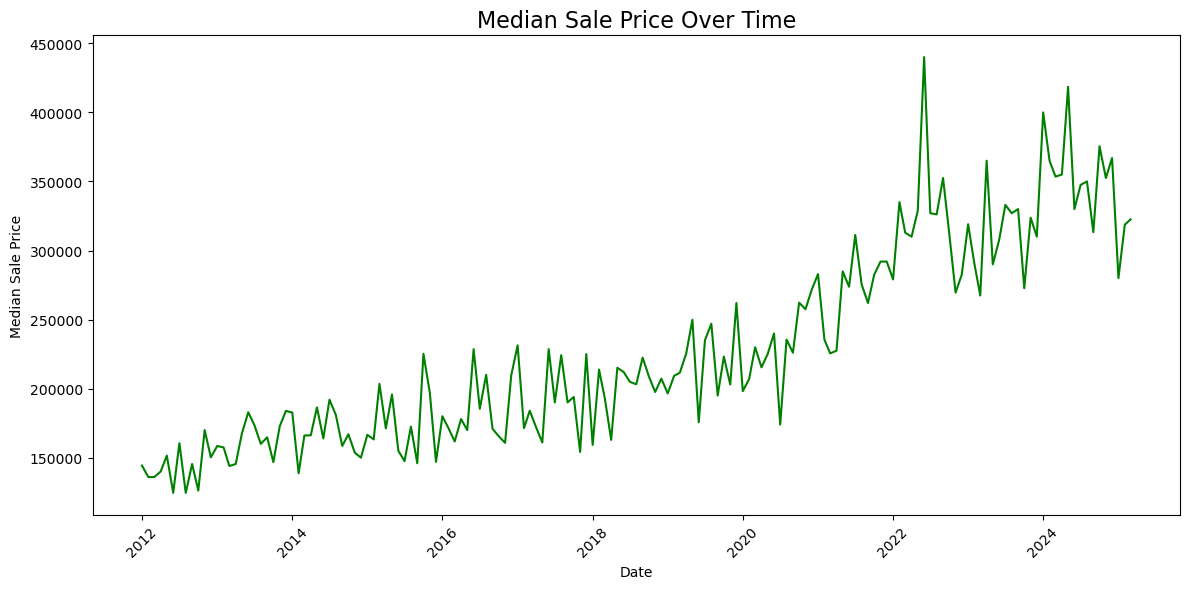

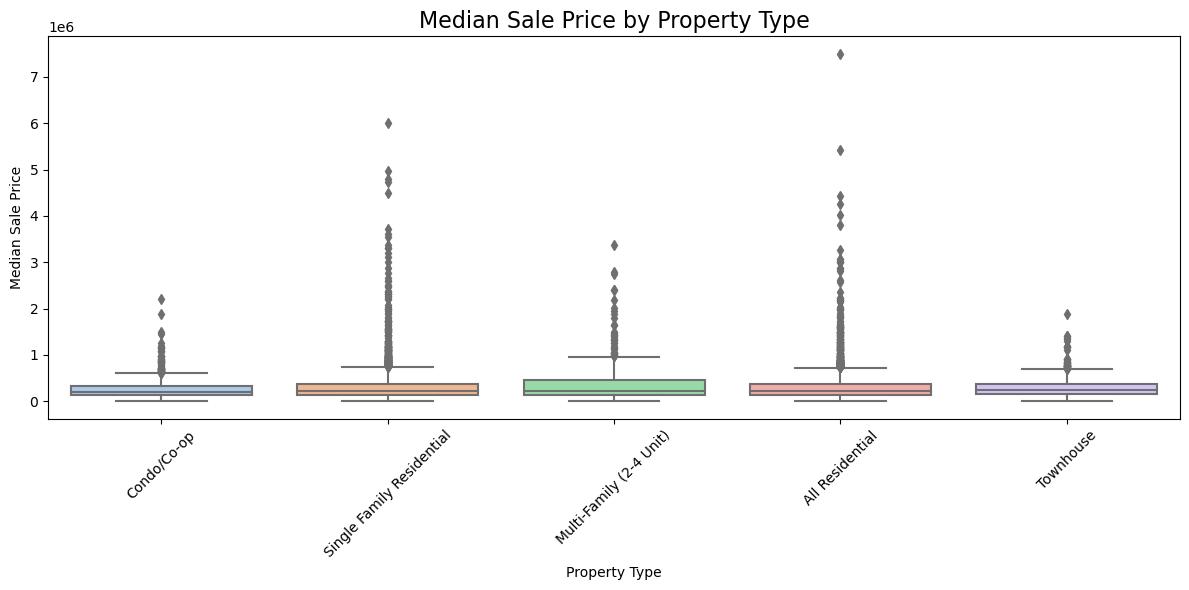

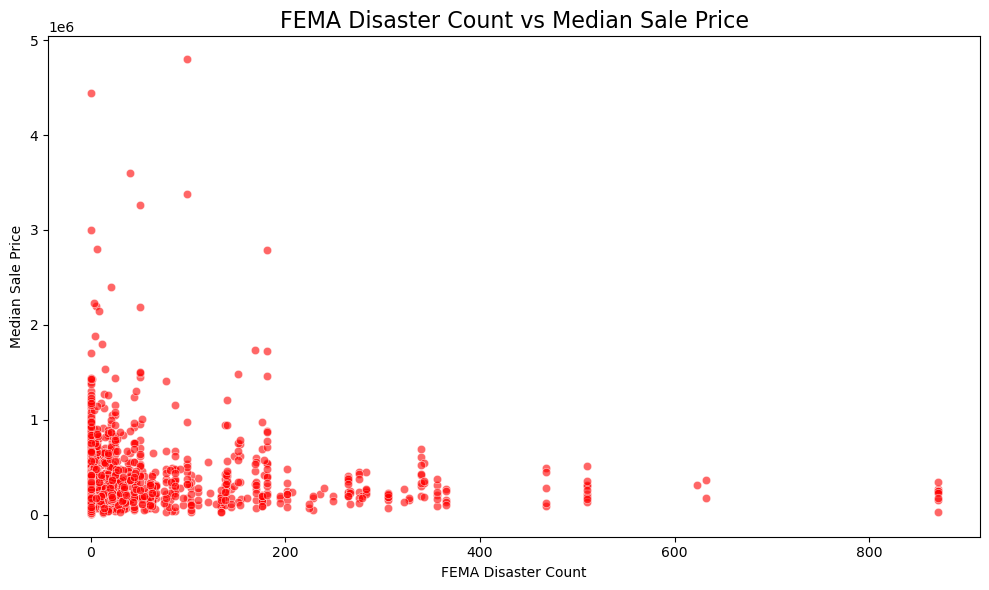

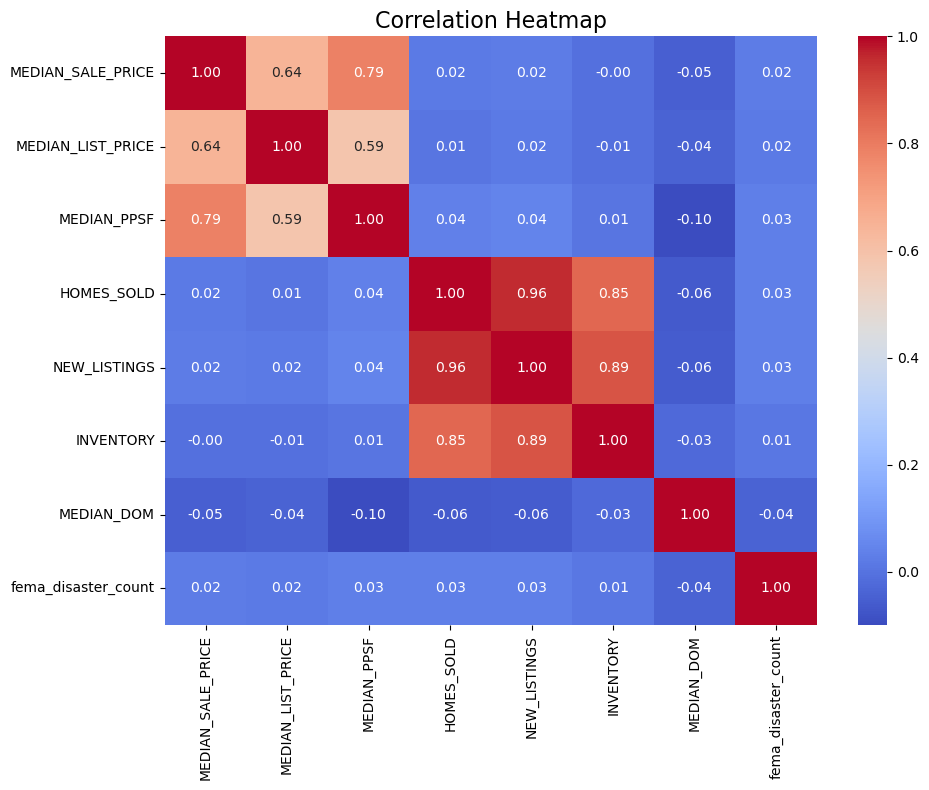

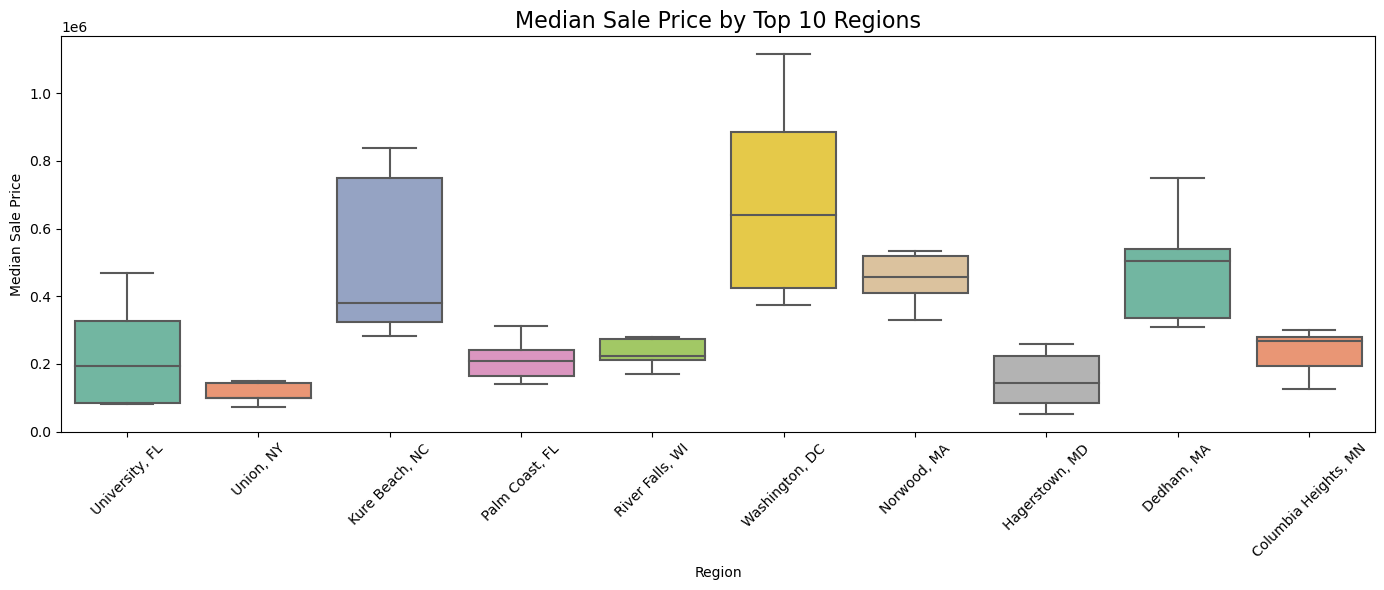

/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


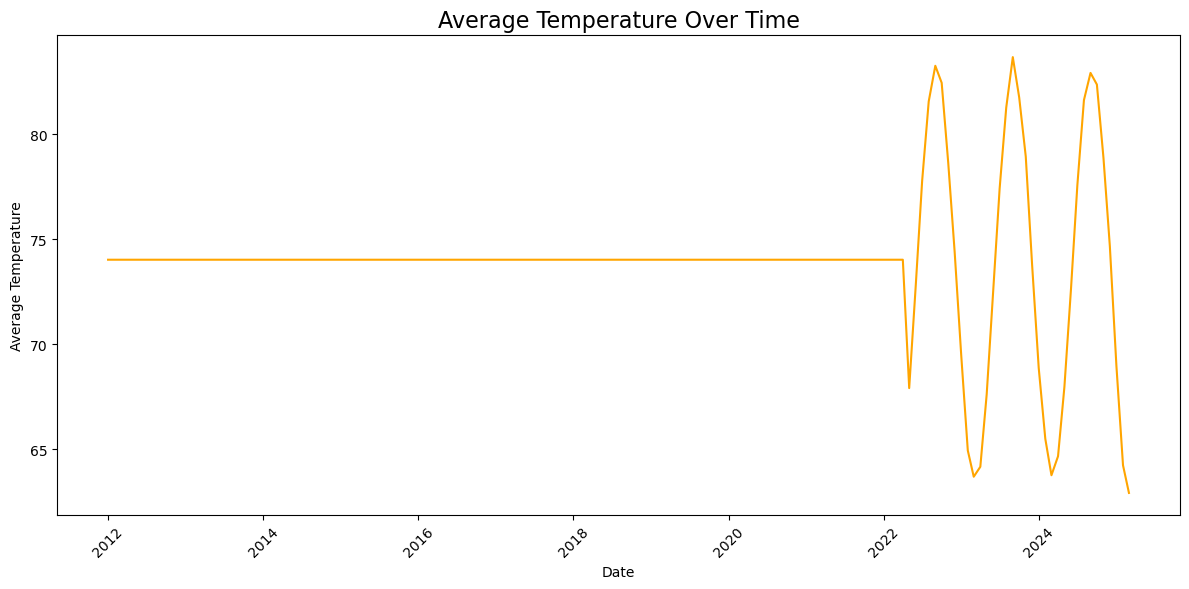

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load a sample for fast plotting
df = pd.read_csv('redfin_with_fema_noaa_cleaned.csv', na_values=['null', 'NULL'])
df = df.sample(n=10000, random_state=42)
df['PERIOD_BEGIN'] = pd.to_datetime(df['PERIOD_BEGIN'], errors='coerce')

# 1. Distribution of Median Sale Price
plt.figure(figsize=(10, 6))
sns.histplot(df['MEDIAN_SALE_PRICE'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Median Sale Price', fontsize=16)
plt.xlabel('Median Sale Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Median Sale Price Over Time
median_price_time = df.groupby('PERIOD_BEGIN')['MEDIAN_SALE_PRICE'].median().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=median_price_time, x='PERIOD_BEGIN', y='MEDIAN_SALE_PRICE', color='green')
plt.title('Median Sale Price Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Boxplot: Median Sale Price by Property Type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='PROPERTY_TYPE', y='MEDIAN_SALE_PRICE', palette='pastel')
plt.title('Median Sale Price by Property Type', fontsize=16)
plt.xlabel('Property Type')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Scatter: FEMA Disaster Count vs Median Sale Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(2000, random_state=42), x='fema_disaster_count', y='MEDIAN_SALE_PRICE', alpha=0.6, color='red')
plt.title('FEMA Disaster Count vs Median Sale Price', fontsize=16)
plt.xlabel('FEMA Disaster Count')
plt.ylabel('Median Sale Price')
plt.tight_layout()
plt.show()

# 5. Correlation Heatmap of Key Numeric Features
numeric_cols = ['MEDIAN_SALE_PRICE', 'MEDIAN_LIST_PRICE', 'MEDIAN_PPSF', 'HOMES_SOLD', 'NEW_LISTINGS', 'INVENTORY', 'MEDIAN_DOM', 'fema_disaster_count']
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# 6. Boxplot: Median Sale Price by Top 10 Regions
plt.figure(figsize=(14, 6))
top_regions = df['REGION'].value_counts().nlargest(10).index
sns.boxplot(data=df[df['REGION'].isin(top_regions)], x='REGION', y='MEDIAN_SALE_PRICE', palette='Set2')
plt.title('Median Sale Price by Top 10 Regions', fontsize=16)
plt.xlabel('Region')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Line plot: Average Temperature Over Time
if 'avg_temp' in df.columns:
    temp_time = df.groupby('PERIOD_BEGIN')['avg_temp'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=temp_time, x='PERIOD_BEGIN', y='avg_temp', color='orange')
    plt.title('Average Temperature Over Time', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Average Temperature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


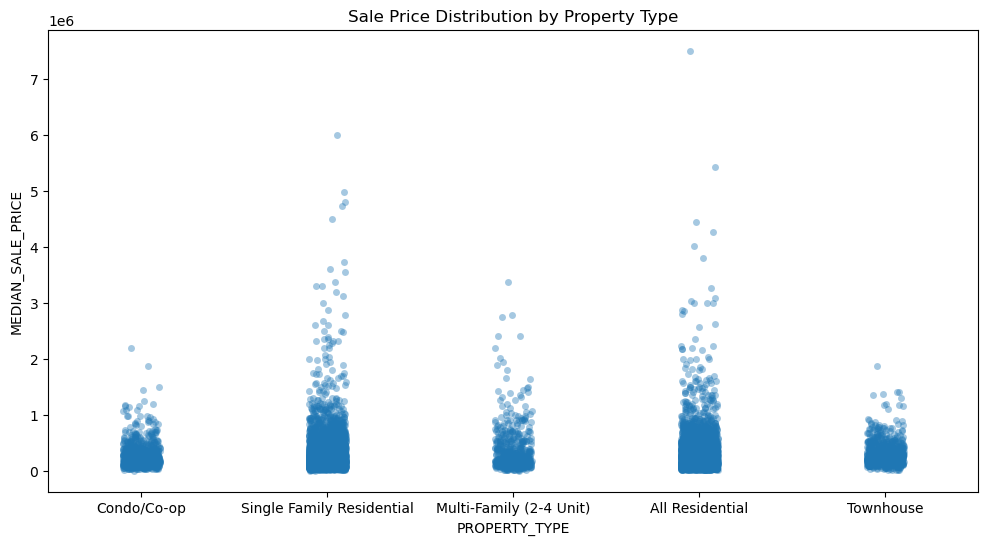

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.stripplot(data=df, x='PROPERTY_TYPE', y='MEDIAN_SALE_PRICE', jitter=True, alpha=0.4)
plt.title('Sale Price Distribution by Property Type')
plt.show()




/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


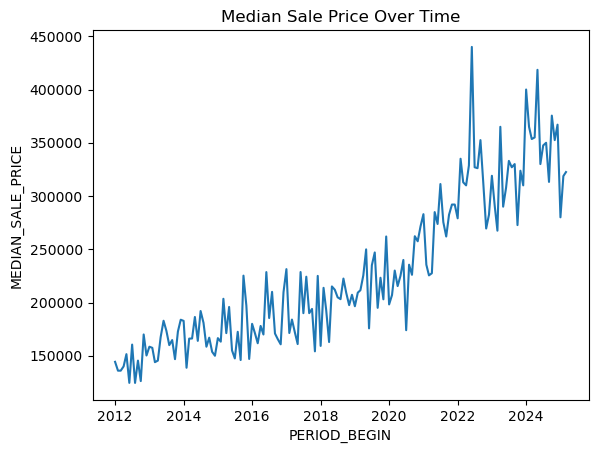

In [8]:
df['PERIOD_BEGIN'] = pd.to_datetime(df['PERIOD_BEGIN'])
monthly = df.groupby('PERIOD_BEGIN')['MEDIAN_SALE_PRICE'].median().reset_index()
sns.lineplot(data=monthly, x='PERIOD_BEGIN', y='MEDIAN_SALE_PRICE')
plt.title('Median Sale Price Over Time')
plt.show()


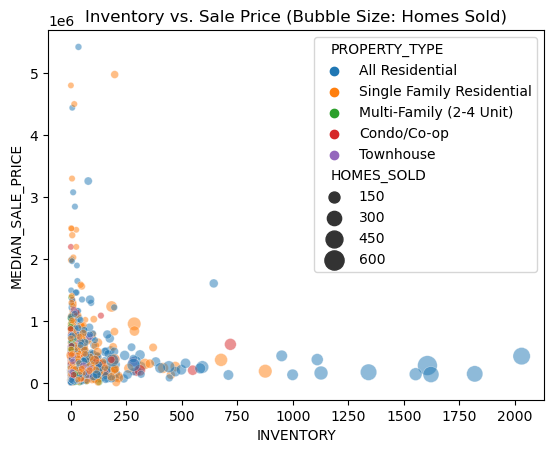

In [9]:
sns.scatterplot(
    data=df.sample(2000),
    x='INVENTORY', y='MEDIAN_SALE_PRICE',
    size='HOMES_SOLD', hue='PROPERTY_TYPE', alpha=0.5, sizes=(20, 200)
)
plt.title('Inventory vs. Sale Price (Bubble Size: Homes Sold)')
plt.show()



/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


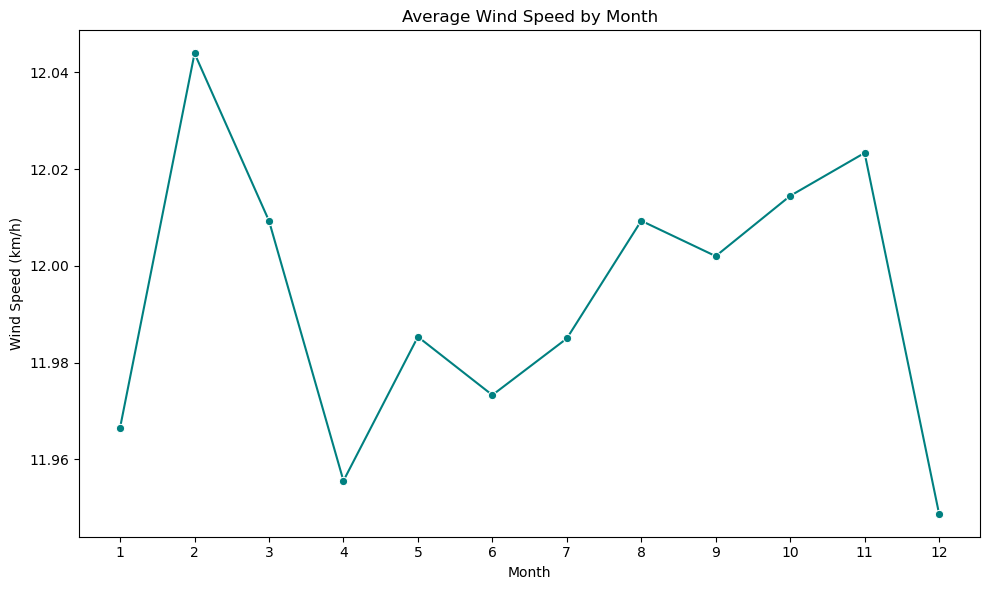

/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


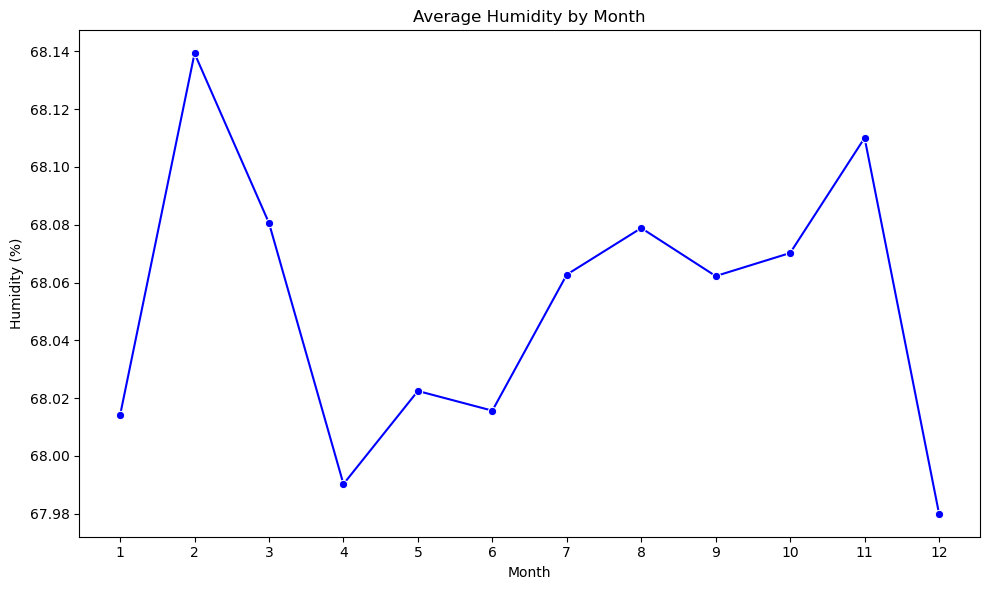

/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

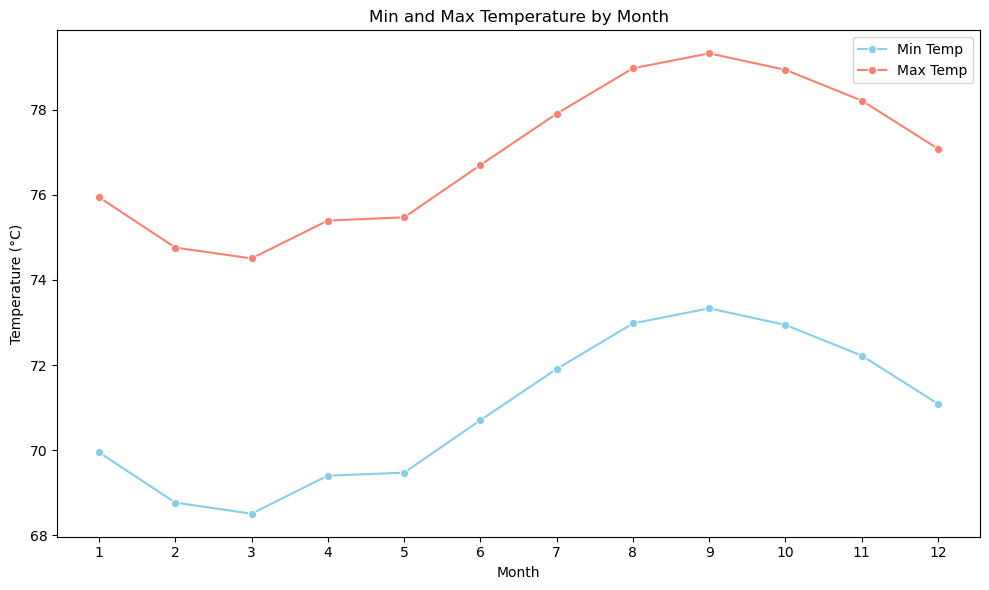

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Line plot: Average wind speed by month
monthly_wind = df.groupby('MONTH')['wind_speed'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='MONTH', y='wind_speed', data=monthly_wind, marker='o', color='teal')
plt.title('Average Wind Speed by Month')
plt.xlabel('Month')
plt.ylabel('Wind Speed (km/h)')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()



# 2. Line plot: Average humidity by month
monthly_humidity = df.groupby('MONTH')['humidity'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='MONTH', y='humidity', data=monthly_humidity, marker='o', color='blue')
plt.title('Average Humidity by Month')
plt.xlabel('Month')
plt.ylabel('Humidity (%)')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


# 3. Line plot: Min and Max temperature over months
monthly_temp = df.groupby('MONTH')[['min_temp','max_temp']].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='MONTH', y='min_temp', data=monthly_temp, marker='o', label='Min Temp', color='skyblue')
sns.lineplot(x='MONTH', y='max_temp', data=monthly_temp, marker='o', label='Max Temp', color='salmon')
plt.title('Min and Max Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


/var/folders/1n/jwf7cym1789ghbzgwdcxd1140000gn/T/ipykernel_65819/231761169.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='PROPERTY_TYPE', y='MEDIAN_SALE_PRICE', data=df, ci=None, palette='Set2')


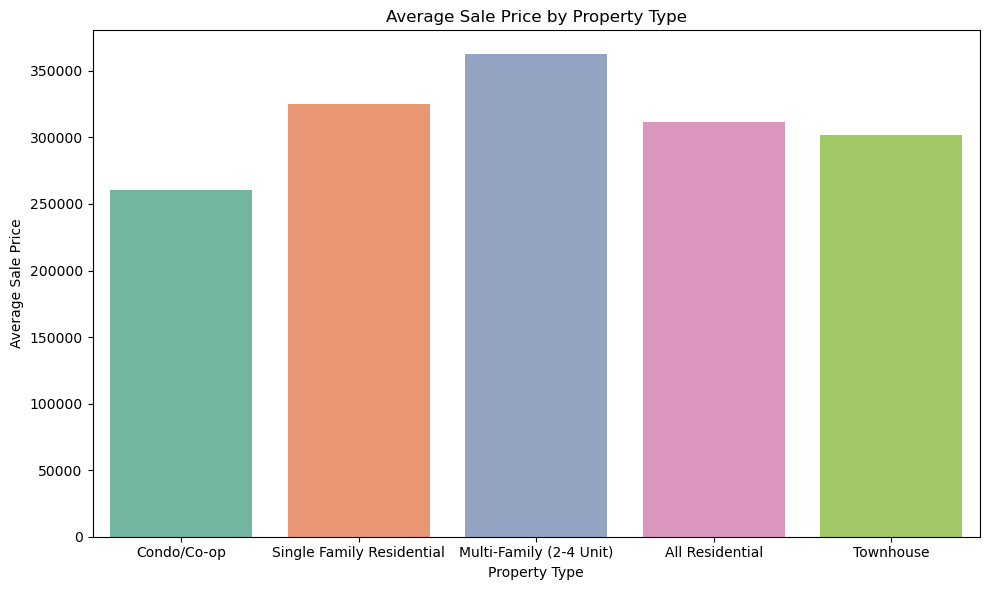

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(x='PROPERTY_TYPE', y='MEDIAN_SALE_PRICE', data=df, ci=None, palette='Set2')
plt.title('Average Sale Price by Property Type')
plt.ylabel('Average Sale Price')
plt.xlabel('Property Type')
plt.tight_layout()
plt.show()


/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

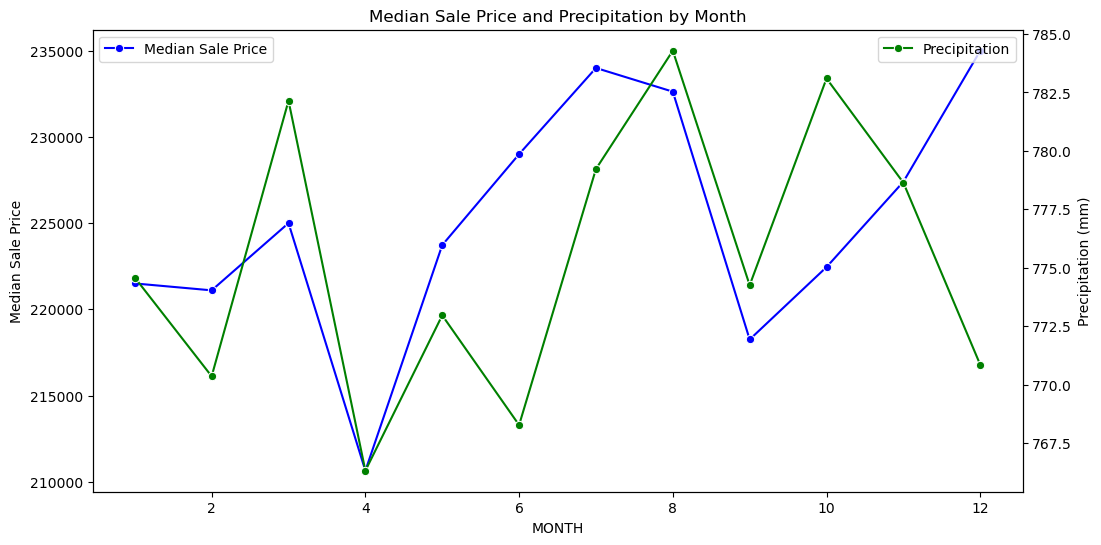

In [12]:
monthly = df.groupby('MONTH').agg({'MEDIAN_SALE_PRICE':'median', 'precipitation':'mean'}).reset_index()
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
sns.lineplot(x='MONTH', y='MEDIAN_SALE_PRICE', data=monthly, marker='o', color='blue', ax=ax1, label='Median Sale Price')
sns.lineplot(x='MONTH', y='precipitation', data=monthly, marker='o', color='green', ax=ax2, label='Precipitation')
ax1.set_ylabel('Median Sale Price')
ax2.set_ylabel('Precipitation (mm)')
plt.title('Median Sale Price and Precipitation by Month')
plt.show()


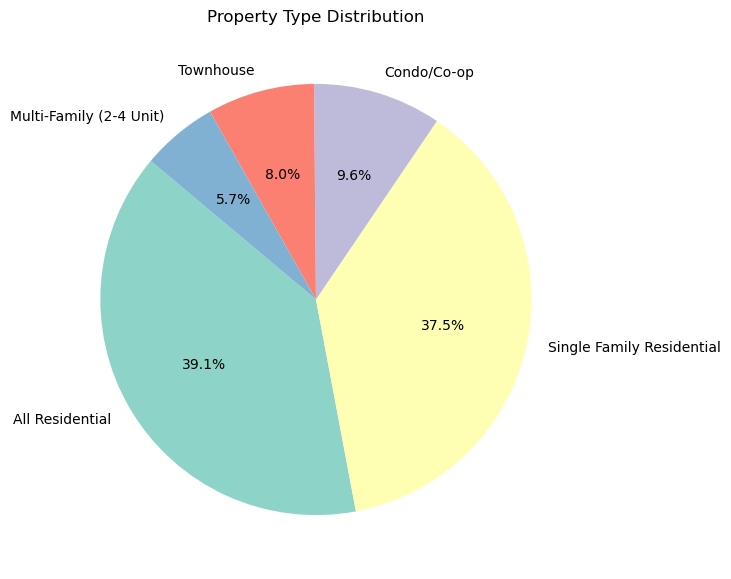

In [13]:
plt.figure(figsize=(7,7))
df['PROPERTY_TYPE'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.title('Property Type Distribution')
plt.ylabel('')
plt.show()


/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


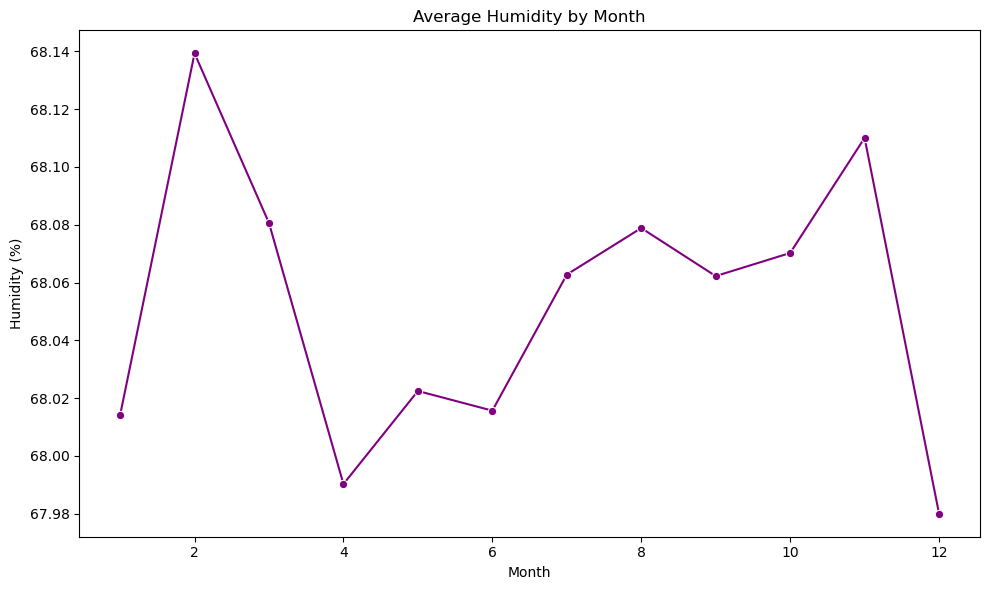

In [14]:
monthly_humidity = df.groupby('MONTH')['humidity'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='MONTH', y='humidity', data=monthly_humidity, marker='o', color='purple')
plt.title('Average Humidity by Month')
plt.xlabel('Month')
plt.ylabel('Humidity (%)')
plt.tight_layout()
plt.show()


/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/soumitra7/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

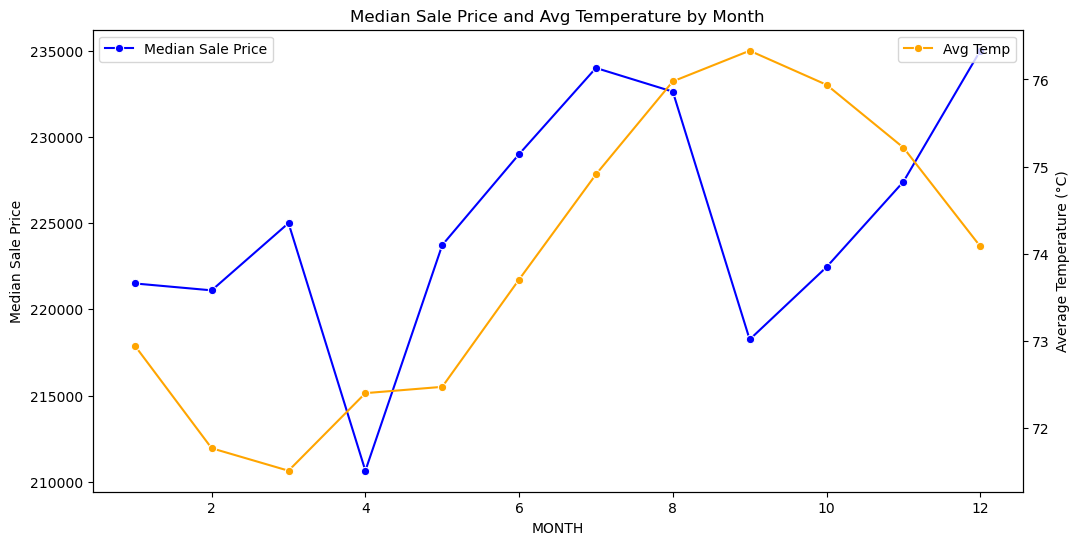

In [15]:
monthly_temp = df.groupby('MONTH').agg({'MEDIAN_SALE_PRICE':'median', 'avg_temp':'mean'}).reset_index()
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
sns.lineplot(x='MONTH', y='MEDIAN_SALE_PRICE', data=monthly_temp, marker='o', color='blue', ax=ax1, label='Median Sale Price')
sns.lineplot(x='MONTH', y='avg_temp', data=monthly_temp, marker='o', color='orange', ax=ax2, label='Avg Temp')
ax1.set_ylabel('Median Sale Price')
ax2.set_ylabel('Average Temperature (°C)')
plt.title('Median Sale Price and Avg Temperature by Month')
plt.show()


# Risk Assesment

In [17]:
import pandas as pd

# Revised thresholds and scores to prevent 100% maximum
RISK_WEIGHTS = {
    'fema_disaster_count': {
        'thresholds': [0, 3, 6, 10, 15],  # Added higher threshold
        'scores':    [0, 10, 20, 30, 40]   # Reduced maximum points
    },
    'natural_disaster_score': {
        'thresholds': [0, 10, 20, 30, 40],  # Extended scale
        'scores':    [0, 15, 30, 45, 50]    # Reduced maximum
    },
    'precipitation': {
        'thresholds': [0, 2, 4, 6, 8],     # Added higher threshold
        'scores':    [0, 10, 20, 30, 35]   # Adjusted maximum
    },
    'INVENTORY': {
        'thresholds': [0, 50, 100, 150, 200],  # Added higher threshold
        'scores':    [0, 5, 10, 15, 20]        # Reduced maximum
    }
}

def calculate_absolute_risk(row):
    """Calculate risk using tiered thresholds"""
    total = 0
    for feature, params in RISK_WEIGHTS.items():
        value = row[feature]
        # Find the appropriate score bracket
        for i, threshold in enumerate(params['thresholds']):
            if value < threshold:
                total += params['scores'][i-1] if i > 0 else 0
                break
        else:  # If value exceeds all thresholds
            total += params['scores'][-1]
    return total

# Load data
df = pd.read_csv('redfin_with_fema_noaa_cleaned.csv')

# Calculate absolute risk
df['ABSOLUTE_RISK'] = df.apply(calculate_absolute_risk, axis=1)

# Calculate realistic maximum (now 40+50+35+20=145 instead of 165)
max_possible = sum([v['scores'][-1] for v in RISK_WEIGHTS.values()])

# Normalize to 0-95 scale (leaves room for future extreme cases)
df['ABSOLUTE_RISK'] = (df['ABSOLUTE_RISK'] / max_possible) * 95

print(df[['CITY', 'STATE', 'ABSOLUTE_RISK']].sort_values('ABSOLUTE_RISK', ascending=False).head(10))


                   CITY       STATE  ABSOLUTE_RISK
2801494  Lake Arrowhead  CALIFORNIA      91.724138
3480582      Long Beach  CALIFORNIA      91.724138
2777060  Lake Arrowhead  CALIFORNIA      91.724138
637390        La Quinta  CALIFORNIA      91.724138
3323303          Corona  CALIFORNIA      91.724138
2614681      Long Beach  CALIFORNIA      91.724138
2776768         Fontana  CALIFORNIA      91.724138
5715541         Oakland  CALIFORNIA      91.724138
2511181  Lake Arrowhead  CALIFORNIA      91.724138
1949152         Fontana  CALIFORNIA      91.724138


In [18]:
import pandas as pd

# Revised thresholds and scores
RISK_WEIGHTS = {
    'fema_disaster_count': {
        'thresholds': [0, 3, 6, 10, 15],
        'scores':    [0, 10, 20, 30, 40]
    },
    'natural_disaster_score': {
        'thresholds': [0, 10, 20, 30, 40],
        'scores':    [0, 15, 30, 45, 50]
    },
    'precipitation': {
        'thresholds': [0, 2, 4, 6, 8],
        'scores':    [0, 10, 20, 30, 35]
    },
    'INVENTORY': {
        'thresholds': [0, 50, 100, 150, 200],
        'scores':    [0, 5, 10, 15, 20]
    }
}

def calculate_absolute_risk(row):
    total = 0
    for feature, params in RISK_WEIGHTS.items():
        value = row[feature]
        for i, threshold in enumerate(params['thresholds']):
            if value < threshold:
                total += params['scores'][i-1] if i > 0 else 0
                break
        else:
            total += params['scores'][-1]
    return total

# Load data and calculate scores
df = pd.read_csv('redfin_with_fema_noaa_cleaned.csv')
df['ABSOLUTE_RISK'] = df.apply(calculate_absolute_risk, axis=1)
max_possible = sum([v['scores'][-1] for v in RISK_WEIGHTS.values()])
df['ABSOLUTE_RISK'] = (df['ABSOLUTE_RISK'] / max_possible) * 95

# Filter and display Alabama results
alabama_df = df[df['STATE'].str.upper() == 'ALABAMA']
print("\nAlabama Cities Risk Scores:")
print(alabama_df[['CITY', 'STATE', 'ABSOLUTE_RISK']]
      .sort_values('ABSOLUTE_RISK', ascending=False)
      .head(10)
      .to_string(index=False))



Alabama Cities Risk Scores:
       CITY   STATE  ABSOLUTE_RISK
     Daphne ALABAMA      81.896552
Gulf Shores ALABAMA      81.896552
 Montgomery ALABAMA      81.896552
Gulf Shores ALABAMA      81.896552
Gulf Shores ALABAMA      81.896552
    Madison ALABAMA      81.896552
    Madison ALABAMA      81.896552
    Madison ALABAMA      81.896552
    Madison ALABAMA      81.896552
     Daphne ALABAMA      81.896552


In [19]:
import pandas as pd
import numpy as np

# Optimized risk calculation parameters
RISK_WEIGHTS = {
    'fema_disaster_count': {
        'thresholds': [0, 2, 5, 10, 20],
        'scores':    [10, 20, 35, 50, 60]
    },
    'natural_disaster_score': {
        'thresholds': [0, 10, 20, 30, 40],
        'scores':    [15, 30, 45, 60, 70]
    },
    'precipitation': {
        'thresholds': [0, 2, 4, 6, 8],
        'scores':    [10, 20, 30, 40, 50]
    },
    'INVENTORY': {
        'thresholds': [0, 50, 100, 200, 300],
        'scores':    [5, 10, 15, 20, 25]
    }
}

def calculate_balanced_risk(row):
    """Calculate risk with compressed scaling and minimum baseline"""
    total = 0
    for feature, params in RISK_WEIGHTS.items():
        value = row[feature]
        for i, threshold in enumerate(params['thresholds']):
            if value < threshold:
                total += params['scores'][i-1] if i > 0 else 0
                break
        else:
            total += params['scores'][-1]
    
    # Apply square root compression and normalize
    compressed = np.sqrt(total)
    max_possible = np.sqrt(sum(v['scores'][-1] for v in RISK_WEIGHTS.values()))
    return min(95, (compressed / max_possible) * 100)  # Hard cap at 95

# Load data
df = pd.read_csv('redfin_with_fema_noaa_cleaned.csv')

# Calculate scores
df['RISK_SCORE'] = df.apply(calculate_balanced_risk, axis=1)

# Add minimum score floor of 5
df['RISK_SCORE'] = df['RISK_SCORE'].clip(lower=5)

print(df[['CITY', 'STATE', 'RISK_SCORE']]
      .sort_values('RISK_SCORE', ascending=False)
      .head(10))


                     CITY       STATE  RISK_SCORE
3986152         Elk Grove  CALIFORNIA        95.0
980392         Santa Rosa  CALIFORNIA        95.0
886225         Santa Rosa  CALIFORNIA        95.0
2521100  Huntington Beach  CALIFORNIA        95.0
1127818           Fontana  CALIFORNIA        95.0
5460986    Lake Arrowhead  CALIFORNIA        95.0
4118753    Lake Arrowhead  CALIFORNIA        95.0
1022806    Lake Arrowhead  CALIFORNIA        95.0
4395963         La Quinta  CALIFORNIA        95.0
4452457           Ventura  CALIFORNIA        95.0


In [20]:
import pandas as pd
import numpy as np

# --- Risk scoring function (as above) ---
RISK_WEIGHTS = {
    'fema_disaster_count': {
        'thresholds': [0, 2, 5, 10, 20],
        'scores':    [10, 20, 35, 50, 60]
    },
    'natural_disaster_score': {
        'thresholds': [0, 10, 20, 30, 40],
        'scores':    [15, 30, 45, 60, 70]
    },
    'precipitation': {
        'thresholds': [0, 2, 4, 6, 8],
        'scores':    [10, 20, 30, 40, 50]
    },
    'INVENTORY': {
        'thresholds': [0, 50, 100, 200, 300],
        'scores':    [5, 10, 15, 20, 25]
    }
}

def calculate_balanced_risk(row):
    total = 0
    for feature, params in RISK_WEIGHTS.items():
        value = row[feature]
        for i, threshold in enumerate(params['thresholds']):
            if value < threshold:
                total += params['scores'][i-1] if i > 0 else 0
                break
        else:
            total += params['scores'][-1]
    compressed = np.sqrt(total)
    max_possible = np.sqrt(sum(v['scores'][-1] for v in RISK_WEIGHTS.values()))
    return min(95, (compressed / max_possible) * 100)

# --- Load and process data ---
df = pd.read_csv('redfin_with_fema_noaa_cleaned.csv')

# Calculate risk score
df['RISK_SCORE'] = df.apply(calculate_balanced_risk, axis=1)
df['RISK_SCORE'] = df['RISK_SCORE'].clip(lower=5)

# Filter for the specified states
target_states = ['CALIFORNIA', 'MARYLAND', 'VIRGINIA', 'FLORIDA', 
                 'ALABAMA', 'ARKANSAS', 'TEXAS', 'MINNESOTA']
filtered_df = df[df['STATE'].str.upper().isin(target_states)]

# Get top 10 cities by risk score (dropping duplicates to show unique cities)
top_cities = filtered_df[['CITY', 'STATE', 'RISK_SCORE']] \
    .drop_duplicates(['CITY', 'STATE']) \
    .sort_values('RISK_SCORE', ascending=False) \
    .head(10)

print("Top 10 cities by risk score in selected states:")
print(top_cities)


Top 10 cities by risk score in selected states:
                  CITY       STATE  RISK_SCORE
3617    Lake Arrowhead  CALIFORNIA   95.000000
34851  California City  CALIFORNIA   94.996791
6173            Corona  CALIFORNIA   94.996791
9807      Palm Springs  CALIFORNIA   93.704257
2872       Palm Desert  CALIFORNIA   93.704257
7508           Atwater  CALIFORNIA   93.704257
31263           Odessa       TEXAS   93.704257
10672         Lakeland     FLORIDA   93.704257
33548         Pearland       TEXAS   93.704257
7629      Four Corners     FLORIDA   93.704257


In [21]:
print(df.columns.tolist())


['PERIOD_BEGIN', 'PERIOD_END', 'PERIOD_DURATION', 'REGION_TYPE', 'IS_SEASONALLY_ADJUSTED', 'REGION', 'CITY', 'STATE', 'STATE_CODE', 'PROPERTY_TYPE', 'MEDIAN_SALE_PRICE', 'MEDIAN_SALE_PRICE_MOM', 'MEDIAN_SALE_PRICE_YOY', 'MEDIAN_LIST_PRICE', 'MEDIAN_LIST_PRICE_MOM', 'MEDIAN_LIST_PRICE_YOY', 'MEDIAN_PPSF', 'MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF', 'MEDIAN_LIST_PPSF_MOM', 'MEDIAN_LIST_PPSF_YOY', 'HOMES_SOLD', 'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES', 'PENDING_SALES_MOM', 'PENDING_SALES_YOY', 'NEW_LISTINGS', 'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'INVENTORY', 'INVENTORY_MOM', 'INVENTORY_YOY', 'MONTHS_OF_SUPPLY', 'MONTHS_OF_SUPPLY_MOM', 'MONTHS_OF_SUPPLY_YOY', 'MEDIAN_DOM', 'MEDIAN_DOM_MOM', 'MEDIAN_DOM_YOY', 'AVG_SALE_TO_LIST', 'AVG_SALE_TO_LIST_MOM', 'AVG_SALE_TO_LIST_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM', 'SOLD_ABOVE_LIST_YOY', 'PRICE_DROPS', 'PRICE_DROPS_MOM', 'PRICE_DROPS_YOY', 'OFF_MARKET_IN_TWO_WEEKS', 'OFF_MARKET_IN_TWO_WEEKS_MOM', 'OFF_MARKET_IN

In [ ]:
pip install --upgrade scikit-learn xgboost
